# Investment and Trading Capstone Project

### Project Overview

Investment firms, hedge funds, and even individuals or day traders have been using financial models to better understand market behavior and make profitable investments and trades. A wealth of information is available in the form of historical stock prices and company performance data, suitable for machine learning algorithms to process. According to an article by Mark Kolakowski ["How Robots Rule the Stock Market (SPX, DJIA)"](https://www.investopedia.com/news/how-robots-rule-stock-market-spx-djia):

> only 10% of trading volume now comes from human discretionary investors, per data from JPMorgan Chase & Co. (JPM) cited by Bloomberg

![Crypto Trading Robot Image](https://insidebitcoins.com/wp-content/uploads/2020/05/automated_forex_robot-1200x900-1-768x576.jpg)
##### Source: "Best Forex Robots 2021" by Kane Pepi at https://insidebitcoins.com/forex-robot
---

This project will show how I create a machine learning model to predict stock prices. I will examine and include or rule out factors like leading financial indicators and build out a model using historical data from a real data market data API, and then evaluate the results and accuracy of the model. I will then conclude by developing a Content Based Recommendation engine which will recommend additional stocks based on user selections. The hope is to develop a recommendation engine that provides novelty and potential serendipity: stocks that are similar but in different industries that were initially not considered. 

### Problem Statement
For this project, we will build a stock price predictor that takes daily trading data over a certain date range as input, and outputs projected estimates for given query dates. Note that the inputs will contain multiple metrics, such as opening price (Open), highest price the stock traded at (High), how many stocks were traded (Volume) and closing price adjusted for stock splits and dividends (Adjusted Close); we only need to predict the Adjusted Close price.

This Jupyter Notebook will demonstrate the data wrangling, exploratory data analysis, and show how I will build out the prediction model using Machine Learning techniques and then evaluate the results. In addition, I will also demonstrate a Content Based Recommendation engine that will select similar stocks based on the selection. The other major part will be a hosted web application that allows the user to search for an equity name or stock, using the Yahoo Finance API, and then running the prediction model against the select equity name, but this is not part of this Notebook.

By following the table of contents, I will show the steps I took in perfomring some data wrangling, exploring the data, building out a prediction model, and then showing a Content Based Recommendation engine for making stock recommendations. 


## Table of Contents

I. [Data Wrangling](#Data-Wrangling)<br>
II. [Analysis - Data Exploration and Visualization](#Analysis-Data-Exploration-and-Visualization)<br>
III. [Machine Learning Model](#Machine-Learning-Model)<br>
IV. [Implementation - The Stock Predictor](#The-Stock-Predictor)<br>
V. [Content Based Recommendations](#Content-Based-Recommendations)<br>
VI. [Summary and Conclusion](#Summary-and-Conclusion)

First let us set up some of the Python modules we will need for our exercise.

In [1]:
# From: https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install seaborn

### <a class="anchor" id="Data-Wrangling">Part I : Data Wrangling</a>

For our primary data source of market data and historical data, we considered a few suggestions like [Yahoo! Finance API](https://www.yahoofinanceapi.com), [Bloomberg API](https://www.bloomberg.com/professional/support/api-library/), and [NASDAQ Financial API](https://data.nasdaq.com/tools/api) as per our [Udacity Project Description](https://docs.google.com/document/d/1ycGeb1QYKATG6jvz74SAMqxrlek9Ed4RYrzWNhWS-0Q/pub). My Wall Street background immediately drew me to Bloomberg as the obvious choice, but there are pricing and licensing limitations that come with Bloomberg. So I decided on Yahoo! Finance mainly because there was no need to sign up and I found a lot of online references for Python rather easily. For this notebook I only need a one time data export, but for our web application we want an API that is easy to use and well documented. So that is what ultimately drove my decision. I downloaded the data with the following code and saved the csv file for the analysis:

```
import yfinance as yf  
import matplotlib.pyplot as plt

data = yf.download('BTC-USD','2021-01-01','2021-12-31')
data = data.reset_index()

data["Close"].plot()
data.to_csv("data/bitcoin_stock_2021.csv", index=False)

plt.show()

```
##### Caveat Emptor and Disclaimer
APIs and specially Financial Markets APIs like Yahoo! Finance have limits on how much data you can pull and how frequently. For this notebook, I will not run code like the one above to avoid hit these limits, and heaven forbid, get rate limited or blacklisted. I will show how we can cache requests as much as possible so that I am not hitting the API as frequently. Since this is an academic exercise I am not concerned with real-time accuracy just data to run the models against, so data is cached on a per day basis: meaning, we call the API once per symbol and date range, and store the results in a dictionary so as to minimize the amount of times we call the API.

**My disclaimer: I am not a certified financial planner nor a financial advisor nor a certified financial analyst nor an economist nor a CPA. These predictions and recommendations are only for academic purposes and not an official recommendation from Udacity nor from my employer RSM in any way.**

#### Other Financial Indicators
As part of the data wrangling, I also wanted to bring in other factors I feel have an effect on stock prices in general. Some of this data like the Department of Labor Weekly Unemployment Numbers will require some wrangling to extrapolate a daily number since it is published weekly and some will be easy to both acquire and merge with our stock price and volume data because it is market data that trades with a stock ticker. So I also pulled that down and saved to the data folder like with the stock price data.

1. Weekly Unemployment Numbers from https://oui.doleta.gov/unemploy/claims.asp: unemployment numbers typically drive market numbers. I can remember every Thursday when working on Wall Street what a big deal it was when these numbers came out from the US Department of Labor<br>
2. CPI or Consumer Price Index: how well is the consumer market spending is a typical bell weather of consumer confidence<br>
3. DJIA or Dow Jones Industrial Average Index: an overall market indicator<br>
4. Google Global Mobility Report from https://www.google.com/covid19/mobility: how much are people getting around in spite of the COVID-19 global pandemic, filtered down to just US numbers<br>
5. SP&500 Index: ^GSPC ticker: additional market indicator<br>
6. NASDAQ Composite Index: ^IXIC ticker: Over the Counter market indicator<br>

#### Data Preprocessing
The Weekly Unemployment Numbers came as an Excel file, so I opened it in Excel and saved it as a CSV for our convenience: data/DOL_Weekly_Unemployment_US_2021.csv.

For the Google Global Mobility Report, I read in the global report into a Pandas dataframe because this file was too big to simply open in Excel like I did for the Weekly Unemployment Numbers.

```
import pandas as pd
import numpy as np

df = pd.read_csv('data/Global_Mobility_Report.csv')

# Show df to get an idea of the data
df.head()
```

The I noticed it was as expected but more than US national numbers: US state numbers. And also more than just 2021. So I took just the data I needed from this data frame and wrote it out for later use:

```
df_us = df[(df['country_region_code'] == 'US') & (df['date'] >= '2021-01-01')]
df_us.head()
#duplicates_count = df_us.duplicated(subset='date', keep='first').sum()
#assert duplicates_count == 0, "The Google duplicate count should be zero, but it is {}".format(duplicates_count)

# Oops! There are duplicates? No, it's just that Google breaks it down by state/region, so let's ignore that data
# Let's only focus on the US wide numbers. If 'sub_region_1' is not set then this is the US-wide number, what we want
df_us = df_us[~df_us['sub_region_1'].notnull()]
duplicates_count = df_us.duplicated(subset='date', keep='first').sum()
assert duplicates_count == 0, "The Google duplicate count should be zero, but it is {}".format(duplicates_count)
df_us.to_csv("data/Global_Mobility_Report_US_2021.csv", index=False)
```

For the others I kept the format as is in the data folder. So for the analysis that leaves me the following 7 files to merge:

1. Weekly Unemployment Numbers: data/DOL_Weekly_Unemployment_US_2021.csv<br>
2. CPI or Consumer Price Index: data/cpi_index_2021.csv<br>
3. DJIA or Dow Jones Industrial Average Index: data/djia_index_2021<br>
4. Google Global Mobility Report: data/Global_Mobility_Report_US_2021.csv<br>
5. SP&500 Index: data/sp500_index_2021.csv<br>
6. NASDAQ Composite Index: data/nasdaq_composite_index_2021.csv<br>
7. Bitcoin USD Ticker Data: data/bitcoin_stock_2021.csv<br>

In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.datasets import make_classification
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import yfinance as yf
import datetime

%matplotlib inline

# Start with #7, our Stock Ticker Data:
df = pd.read_csv('data/bitcoin_stock_2021.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359
1,2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765
2,2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202
3,2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344
4,2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782


In [12]:
# Make sure we have distinct dates and data for every day available in 2021: 362 days
duplicates_count = df.duplicated(subset='Date', keep='first').sum()
assert duplicates_count == 0, "The duplicate count should be zero, something is wrong."
assert df.shape[0] == 362, "We have 362 days of data not including the last 3 days of 2021 right now"
print("First day {}, last day {}".format(df.Date.min(), df.Date.max()))

First day 2021-01-01, last day 2021-12-28


We are not taking current day numbers to predict the Closing prices because that would mean we would need to wait until end of day to get these and thus defeat the point of trying to make an end of day prediction. So instead, we are using prior day numbers (Open, High, Low, Close, Adj Close, Volume) N-1 to predict the Nth day Adj Close. Kind of like: __"tell me what happened yesterday, and I'll tell you what I think will happen today."__ So we copy over the "predicted" Nth day Adj Close and copy it to the next day by adding a new column "Adj Close Next Day":

In [13]:
# Create the new Adj Close Next Day column
df['Adj Close Next Day'] = np.nan
# For day N we need next day which we don't have (we end currently at 12/28/2021) on the file, so we look it up and plug it in
# from https://finance.yahoo.com/quote/BTC-USD/history/ 12/29/2021 adjusted closing price
df.loc[len(df) - 1, 'Adj Close Next Day'] = 46444.71
# Take next day's Adj Close and put in in the current Adj Close Next Day column
for i in range(0, len(df) - 1):
    df.loc[i, 'Adj Close Next Day'] = df.loc[i+1, 'Adj Close']
# Check the beginning
print(df.head())
# And check the end of the data to confirm
df.tail()

         Date          Open          High           Low         Close  \
0  2021-01-01  28994.009766  29600.626953  28803.585938  29374.152344   
1  2021-01-02  29376.455078  33155.117188  29091.181641  32127.267578   
2  2021-01-03  32129.408203  34608.558594  32052.316406  32782.023438   
3  2021-01-04  32810.949219  33440.218750  28722.755859  31971.914062   
4  2021-01-05  31977.041016  34437.589844  30221.187500  33992.429688   

      Adj Close       Volume  Adj Close Next Day  
0  29374.152344  40730301359        32127.267578  
1  32127.267578  67865420765        32782.023438  
2  32782.023438  78665235202        31971.914062  
3  31971.914062  81163475344        33992.429688  
4  33992.429688  67547324782        36824.363281  


,Date,Open,High,Low,Close,Adj Close,Volume,Adj Close Next Day
357,2021-12-24,50806.050781,51814.027344,50514.496094,50822.195312,50822.195312,24367912228,50429.859375
358,2021-12-25,50854.917969,51176.597656,50236.707031,50429.859375,50429.859375,19030650914,50809.515625
359,2021-12-26,50428.691406,51196.378906,49623.105469,50809.515625,50809.515625,20964372926,50640.417969
360,2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,47976.324219
361,2021-12-28,50631.375000,50631.375000,47816.828125,47976.324219,47976.324219,33121511424,46444.710000


In [14]:
# Some additional checks
dayN = df[df['Date'] == '2021-01-01']['Adj Close Next Day'].values[0]
dayNPlus1 = df[df['Date'] == '2021-01-02']['Adj Close'].values[0]
assert dayN == dayNPlus1, "The 1/1/2021 Adj Close Next Day {} should equal next day 1/2/2021 Adj Close but they do not".format(dayN, dayNPlus1)
dayN = df[df['Date'] == '2021-10-31']['Adj Close Next Day'].values[0]
dayNPlus1 = df[df['Date'] == '2021-11-01']['Adj Close'].values[0]
assert dayN == dayNPlus1, "The 10/31/2021 Adj Close Next Day {} should equal next day 11/1/2021 Adj Close but they do not".format(dayN, dayNPlus1)
print("Good. Data checks out. Let's move on!")

Good. Data checks out. Let's move on!


Now let's see how well we can do a linear regression to predict 'Adj Close Next Day' based on our current day numbers. Let's call this first attempt our "basic model."

In [15]:
#Split into explanatory and response variables
X2_basic = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
y2_basic = df['Adj Close Next Day']

#Split into train and test
X_train2_basic, X_test2_basic, y_train2_basic, y_test2_basic = train_test_split(X2_basic, y2_basic, test_size = .30, random_state=42) 

lm_basic_model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())
lm_basic_model.fit(X_train2_basic, y_train2_basic)

#Predict and score the model
y_test_preds2_basic = lm_basic_model.predict(X_test2_basic) 

#Rsquared and y_test
rsquared_score_basic = r2_score(y_test2_basic, y_test_preds2_basic)#r2_score
length_y_test_basic = len(y_test2_basic)#num in y_test

"The BASIC r-squared score for our model was {} on {} values.".format(rsquared_score_basic, length_y_test_basic)

'The BASIC r-squared score for our model was 0.9639442278541873 on 109 values.'

Okay, **0.9639442278541873** on 109 values is not too shabby. Can we make it better? How about introducing some market indicators? Let's start with the weekly unemployment numbers and see if we can do better...

In [16]:
# Load the Weekly unemployment data and do some validation
# Notice we tell Pands the thousands separator so that these numerics are read as numerics and not strings
df1dol = pd.read_csv('data/DOL_Weekly_Unemployment_US_2021.csv', thousands = ',')

# Check the other data
duplicates_count = df1dol.duplicated(subset='Date', keep='first').sum()
assert duplicates_count == 0, "The DOL duplicate count should be zero, but it is {}".format(duplicates_count)
print("DOL First day {}, last day {}, total days {}".format(df1dol.Date.min(), df1dol.Date.max(), df1dol.shape[0]))
# In order for merge to work correctly we also have to make sure our 'Date' column is actually a Date value
df1dol['Date'] = pd.to_datetime(df1dol['Date'])
# Just the Date part
df1dol['Date'] = df1dol['Date'].dt.date

DOL First day 1/16/2021, last day 9/4/2021, total days 48


As I mentioned earlier in this notebook, the Weekly Unemployment data is just that, weekly data. So I only have 48 days of data not 360+ days like the USD Bitcoin stock data. So I will need to impute some data to make this work using the magic of Pands `merge_asof` thanks to user `jezrael` on StackOverFlow.com:

In [17]:
# Since df1dol unemployment numbers are weekly and not daily, we use a merge_asof that we learned from user jezrael
# at https://stackoverflow.com/a/57375728/2788414

df['Time Stamp'] = pd.to_datetime(df['Date'])
df1dol['Time Stamp'] = pd.to_datetime(df1dol['Date'])

df1 = df.sort_values('Time Stamp')
df2 = df1dol.sort_values('Time Stamp')

df_unemp = pd.merge_asof(df1, df2, on='Time Stamp')
df_unemp.head()

,Date_x,Open,High,Low,Close,Adj Close,Volume,Adj Close Next Day,Time Stamp,Date_y,...,Init S.F.,Init S.A.,Init S.A. 4-Week,Continued N.S.A,Continued S.F.,Continued S.A.,Continued S.A. 4-Week,IUR N.S.A,IUR S.A.,Covered Employment
0,2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,32127.267578,2021-01-01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,32782.023438,2021-01-02,2021-01-02,...,118083.0,781000.0,805000.0,5756886.0,517157.0,5240000.0,5291000.0,4.1,3.7,142133208.0
2,2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,31971.914062,2021-01-03,2021-01-02,...,118083.0,781000.0,805000.0,5756886.0,517157.0,5240000.0,5291000.0,4.1,3.7,142133208.0
3,2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,33992.429688,2021-01-04,2021-01-02,...,118083.0,781000.0,805000.0,5756886.0,517157.0,5240000.0,5291000.0,4.1,3.7,142133208.0
4,2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,36824.363281,2021-01-05,2021-01-02,...,118083.0,781000.0,805000.0,5756886.0,517157.0,5240000.0,5291000.0,4.1,3.7,142133208.0


In [18]:
# And the tail end of the data...
df_unemp.tail()

,Date_x,Open,High,Low,Close,Adj Close,Volume,Adj Close Next Day,Time Stamp,Date_y,...,Init S.F.,Init S.A.,Init S.A. 4-Week,Continued N.S.A,Continued S.F.,Continued S.A.,Continued S.A. 4-Week,IUR N.S.A,IUR S.A.,Covered Employment
357,2021-12-24,50806.050781,51814.027344,50514.496094,50822.195312,50822.195312,24367912228,50429.859375,2021-12-24,2021-11-27,...,-9880.0,227000.0,240000.0,1965792.0,-33123.0,1999000.0,2029250.0,1.5,1.5,135015266.0
358,2021-12-25,50854.917969,51176.597656,50236.707031,50429.859375,50429.859375,19030650914,50809.515625,2021-12-25,2021-11-27,...,-9880.0,227000.0,240000.0,1965792.0,-33123.0,1999000.0,2029250.0,1.5,1.5,135015266.0
359,2021-12-26,50428.691406,51196.378906,49623.105469,50809.515625,50809.515625,20964372926,50640.417969,2021-12-26,2021-11-27,...,-9880.0,227000.0,240000.0,1965792.0,-33123.0,1999000.0,2029250.0,1.5,1.5,135015266.0
360,2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,47976.324219,2021-12-27,2021-11-27,...,-9880.0,227000.0,240000.0,1965792.0,-33123.0,1999000.0,2029250.0,1.5,1.5,135015266.0
361,2021-12-28,50631.375000,50631.375000,47816.828125,47976.324219,47976.324219,33121511424,46444.710000,2021-12-28,2021-11-27,...,-9880.0,227000.0,240000.0,1965792.0,-33123.0,1999000.0,2029250.0,1.5,1.5,135015266.0


In [19]:
# But looks like we have data for every day now except day 1
df_unemp[df_unemp['Covered Employment'].isnull()]

,Date_x,Open,High,Low,Close,Adj Close,Volume,Adj Close Next Day,Time Stamp,Date_y,...,Init S.F.,Init S.A.,Init S.A. 4-Week,Continued N.S.A,Continued S.F.,Continued S.A.,Continued S.A. 4-Week,IUR N.S.A,IUR S.A.,Covered Employment
0,2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,32127.267578,2021-01-01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Let's backfill for that one day
df_unemp = df_unemp.bfill()
df_unemp.head()

,Date_x,Open,High,Low,Close,Adj Close,Volume,Adj Close Next Day,Time Stamp,Date_y,...,Init S.F.,Init S.A.,Init S.A. 4-Week,Continued N.S.A,Continued S.F.,Continued S.A.,Continued S.A. 4-Week,IUR N.S.A,IUR S.A.,Covered Employment
0,2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,32127.267578,2021-01-01,2021-01-02,...,118083.0,781000.0,805000.0,5756886.0,517157.0,5240000.0,5291000.0,4.1,3.7,142133208.0
1,2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,32782.023438,2021-01-02,2021-01-02,...,118083.0,781000.0,805000.0,5756886.0,517157.0,5240000.0,5291000.0,4.1,3.7,142133208.0
2,2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,31971.914062,2021-01-03,2021-01-02,...,118083.0,781000.0,805000.0,5756886.0,517157.0,5240000.0,5291000.0,4.1,3.7,142133208.0
3,2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,33992.429688,2021-01-04,2021-01-02,...,118083.0,781000.0,805000.0,5756886.0,517157.0,5240000.0,5291000.0,4.1,3.7,142133208.0
4,2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,36824.363281,2021-01-05,2021-01-02,...,118083.0,781000.0,805000.0,5756886.0,517157.0,5240000.0,5291000.0,4.1,3.7,142133208.0


<AxesSubplot:>

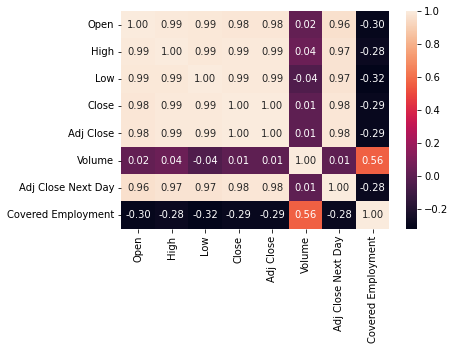

In [21]:
# Now let's check our correlation to 'Adj Close Next Day' but first let's remove some redundant columns
df_plot = df_unemp.drop(['Time Stamp', 'Date_y', 'Init N.S.A', 'Init S.F.', 'Init S.A.', 'Init S.A. 4-Week', 'Continued N.S.A', 'Continued S.F.', 'Continued S.A.', 'Continued S.A. 4-Week', 'IUR N.S.A', 'IUR S.A.'], axis=1)
sns.heatmap(df_plot.corr(), annot=True, fmt=".2f")

A couple of important observations here:

`1.` Covered Employment not only has no correlation, but rather a negative correlation, so we can drop this from our model.<br>
`2.` Volume has almost 0 correlation (0.01), so we can actually drop that from our model as well. Seems that if we wanted to predict Volume that Covered Employment has the correct correlation. This makes sense since high fluctuations in Unemployment Numbers signal market volatility which leads to increase sell offs or buying frenzies.<br>

Given these two observations, let's run our model again and see if we can improve on our model's r-squared number:

In [22]:
#Split into explanatory and response variables
X2_novol = df[['Open', 'High', 'Low', 'Close', 'Adj Close']]
y2_novol = df['Adj Close Next Day']

#Split into train and test
#Note the reason we set shuffle to True here is because sequential or chronologically ordered data should not 
#be randomly split, which is the default behavior for train_test_split. Overriding this behavior makes sense for 
#data which depends on chronological order.
X_train2_novol, X_test2_novol, y_train2_novol, y_test2_novol = train_test_split(X2_novol, y2_novol, test_size = .30, random_state=42, shuffle=False) 

lm_novol_model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())
lm_novol_model.fit(X_train2_novol, y_train2_novol)

#Predict and score the model
y_test_preds2_novol = lm_novol_model.predict(X_test2_novol) 

#Rsquared and y_test
rsquared_score_novol = r2_score(y_test2_novol, y_test_preds2_novol)#r2_score
length_y_test_novol = len(y_test2_novol)#num in y_test

print("The No-Volume r-squared score for our model was {} on {} values.".format(rsquared_score_novol, length_y_test_novol))
print("The No-Volume is better by {}".format(rsquared_score_novol - rsquared_score_basic))

The No-Volume r-squared score for our model was 0.9341313107858845 on 109 values.
The No-Volume is better by -0.029812917068302802


Slightly worse at **0.9341313107858845**, so our original model is better by 0.03. So I will go with the basic model over this one. How about other economic indicator data I wrangled earlier?

Let's track our work as we consider 5 other leading economic indicators, including the Google Global Mobility Report to account for population movement during a global pandemic or the COVID-19 effect:

| No | Indicator | Data Source | Description | Status |
|----|-----------|-------------|-------------|--------|
| 1 | Weekly Unemployment | data/DOL_Weekly_Unemployment_US_2021.csv | I can remember every Thursday when working on Wall Street what a big deal it was when these numbers came out from the US Department of Labor | DONE, no correlation |
| 2 | CPI or Consumer Price Index | data/cpi_index_2021.csv | Indicates strength of consumer market spending, a typical bell weather of consumer confidence | Testing |
| 3 | DJIA or Dow Jones Industrial Average Index | data/djia_index_2021.csv | Overall blue chip market indicator | Testing |
| 4 | Google Global Mobility Report | data/Global_Mobility_Report_US_2021.csv | How much are people getting around in spite of the COVID-19 global pandemic, filtered down to just US numbers | Testing |
| 5 | SP&500 Index | data/sp500_index_2021.csv | ^GSPC ticker: additional market indicator | Testing |
| 6 | NASDAQ Composite Index | data/nasdaq_composite_index_2021.csv | ^IXIC ticker: Over the Counter market indicator | Testing |

Read in our other data now:

In [23]:
# Let us read in the other enconomic indicator data we wrangled earlier in the notebook:
df2cpi = pd.read_csv('data/cpi_index_2021.csv')
df3djia = pd.read_csv('data/djia_index_2021.csv')
df4google = pd.read_csv('data/Global_Mobility_Report_US_2021.csv')
df5snp = pd.read_csv('data/sp500_index_2021.csv')
df6nasdaq = pd.read_csv('data/nasdaq_composite_index_2021.csv')

df2cpi.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,27.280001,27.280001,27.280001,27.280001,27.280001,100
1,2021-01-05,27.270000,27.290001,27.270000,27.280001,27.280001,900
2,2021-01-06,27.260000,27.290001,27.250000,27.260000,27.260000,12700
3,2021-01-07,27.280001,27.309999,27.280001,27.299999,27.299999,8300
4,2021-01-08,27.290001,27.290001,27.150000,27.270000,27.270000,6200


Validate this other data now...

In [24]:
duplicates_count = df2cpi.duplicated(subset='Date', keep='first').sum()
assert duplicates_count == 0, "The CPI duplicate count should be zero, but it is {}".format(duplicates_count)
print("CPI First day {}, last day {}, total days {}".format(df2cpi.Date.min(), df2cpi.Date.max(), df2cpi.shape[0]))
# In order for merge to work correctly we also have to make sure our 'Date' column is actually a Date value
df2cpi['Date'] = pd.to_datetime(df2cpi['Date'])
# Just the Date part
df2cpi['Date'] = df2cpi['Date'].dt.date

duplicates_count = df3djia.duplicated(subset='Date', keep='first').sum()
assert duplicates_count == 0, "The DJIA duplicate count should be zero, but it is {}".format(duplicates_count)
print("DJIA First day {}, last day {}, total days {}".format(df3djia.Date.min(), df3djia.Date.max(), df3djia.shape[0]))
# In order for merge to work correctly we also have to make sure our 'Date' column is actually a Date value
df3djia['Date'] = pd.to_datetime(df3djia['Date'])
# Just the Date part
df3djia['Date'] = df3djia['Date'].dt.date

duplicates_count = df4google.duplicated(subset='date', keep='first').sum()
assert duplicates_count == 0, "The Google duplicate count should be zero, but it is {}".format(duplicates_count)
print("Google First day {}, last day {}, total days {}".format(df4google.date.min(), df4google.date.max(), df4google.shape[0]))
# In order for merge to work correctly we also have to make sure our 'date' column is actually a Date value
df4google['Date'] = pd.to_datetime(df4google['date'])
# Just the Date part
df4google['Date'] = df4google['Date'].dt.date

duplicates_count = df5snp.duplicated(subset='Date', keep='first').sum()
assert duplicates_count == 0, "The S&P duplicate count should be zero, but it is {}".format(duplicates_count)
print("S&P First day {}, last day {}, total days {}".format(df5snp.Date.min(), df5snp.Date.max(), df5snp.shape[0]))
# In order for merge to work correctly we also have to make sure our 'Date' column is actually a Date value
df5snp['Date'] = pd.to_datetime(df5snp['Date'])
# Just the Date part
df5snp['Date'] = df5snp['Date'].dt.date

duplicates_count = df6nasdaq.duplicated(subset='Date', keep='first').sum()
assert duplicates_count == 0, "The NASDAQ duplicate count should be zero, but it is {}".format(duplicates_count)
print("NASDAQ First day {}, last day {}, total days {}".format(df6nasdaq.Date.min(), df6nasdaq.Date.max(), df6nasdaq.shape[0]))
# In order for merge to work correctly we also have to make sure our 'Date' column is actually a Date value
df6nasdaq['Date'] = pd.to_datetime(df6nasdaq['Date'])
# Just the Date part
df6nasdaq['Date'] = df6nasdaq['Date'].dt.date

# DOL has the most "holes" in the data but we knew this because it is weekly numbers that we can simply fill forward later

CPI First day 2021-01-04, last day 2021-12-28, total days 249
DJIA First day 2021-01-04, last day 2021-11-15, total days 218
Google First day 2021-01-01, last day 2021-12-25, total days 359
S&P First day 2021-01-04, last day 2021-12-28, total days 249
NASDAQ First day 2021-01-04, last day 2021-12-28, total days 249


Now let's merge it all into one df_all data frame so we can run some additional correlation analysis...

In [25]:
df_all = df

# Let's do the others
df2cpi['Time Stamp'] = pd.to_datetime(df2cpi['Date'])
# Prefix the type of Date/Open/High/Low/Close columns these are so we can distinguish from our stock ticker numbers
df2cpi.rename(inplace = True, columns={"Date": "CPI Date", "Open": "CPI Open", "High": "CPI High", "Low": "CPI Low", "Close": "CPI Close", "Adj Close": "CPI Adj Close", "Volume": "CPI Volume"})
df2cpi.sort_values('Time Stamp', inplace=True)

df_all = pd.merge_asof(df_all, df2cpi, on='Time Stamp')

df3djia['Time Stamp'] = pd.to_datetime(df3djia['Date'])
# Prefix the type of Date/Open/High/Low/Close columns these are so we can distinguish from our stock ticker numbers
df3djia.rename(inplace = True, columns={"Date": "DJIA Date", "Open": "DJIA Open", "High": "DJIA High", "Low": "DJIA Low", "Close": "DJIA Close", "Adj Close": "DJIA Adj Close", "Volume": "DJIA Volume"})
df3djia.sort_values('Time Stamp', inplace=True)

df_all = pd.merge_asof(df_all, df3djia, on='Time Stamp')

df4google['Time Stamp'] = pd.to_datetime(df4google['date'])
df4google.sort_values('Time Stamp', inplace=True)

df_all = pd.merge_asof(df_all, df4google, on='Time Stamp')

df5snp['Time Stamp'] = pd.to_datetime(df5snp['Date'])
# Prefix the type of Date/Open/High/Low/Close columns these are so we can distinguish from our stock ticker numbers
df5snp.rename(inplace = True, columns={"Date": "S&P Date", "Open": "S&P Open", "High": "S&P High", "Low": "S&P Low", "Close": "S&P Close", "Adj Close": "S&P Adj Close", "Volume": "S&P Volume"})
df5snp.sort_values('Time Stamp', inplace=True)

df_all = pd.merge_asof(df_all, df5snp, on='Time Stamp')

df6nasdaq['Time Stamp'] = pd.to_datetime(df6nasdaq['Date'])
# Prefix the type of Date/Open/High/Low/Close columns these are so we can distinguish from our stock ticker numbers
df6nasdaq.rename(inplace = True, columns={"Date": "NASDAQ Date", "Open": "NASDAQ Open", "High": "NASDAQ High", "Low": "NASDAQ Low", "Close": "NASDAQ Close", "Adj Close": "NASDAQ Adj Close", "Volume": "NASDAQ Volume"})
df6nasdaq.sort_values('Time Stamp', inplace=True)

df_all = pd.merge_asof(df_all, df6nasdaq, on='Time Stamp')

### This is where we captured all the data... df_all.to_csv("data/All_Data.csv", index=False)
print (df_all.columns)

df_all.head(10)

Index(['Date_x', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Adj Close Next Day', 'Time Stamp', 'CPI Date', 'CPI Open', 'CPI High',
       'CPI Low', 'CPI Close', 'CPI Adj Close', 'CPI Volume', 'DJIA Date',
       'DJIA Open', 'DJIA High', 'DJIA Low', 'DJIA Close', 'DJIA Adj Close',
       'DJIA Volume', 'country_region_code', 'country_region', 'sub_region_1',
       'sub_region_2', 'metro_area', 'iso_3166_2_code', 'census_fips_code',
       'place_id', 'date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'Date_y', 'S&P Date',
       'S&P Open', 'S&P High', 'S&P Low', 'S&P Close', 'S&P Adj Close',
       'S&P Volume', 'NASDAQ Date', 'NASDAQ Open', 'NASDAQ High', 'NASDAQ Low',
       'NASDAQ Clo

,Date_x,Open,High,Low,Close,Adj Close,Volume,Adj Close Next Day,Time Stamp,CPI Date,...,S&P Close,S&P Adj Close,S&P Volume,NASDAQ Date,NASDAQ Open,NASDAQ High,NASDAQ Low,NASDAQ Close,NASDAQ Adj Close,NASDAQ Volume
0,2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,32127.267578,2021-01-01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,32782.023438,2021-01-02,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,31971.914062,2021-01-03,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,33992.429688,2021-01-04,2021-01-04,...,3700.649902,3700.649902,5.006680e+09,2021-01-04,12958.519531,12958.719727,12543.240234,12698.450195,12698.450195,6.546740e+09
4,2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,36824.363281,2021-01-05,2021-01-05,...,3726.860107,3726.860107,4.582620e+09,2021-01-05,12665.650391,12828.269531,12665.650391,12818.959961,12818.959961,6.904420e+09
5,2021-01-06,34013.613281,36879.699219,33514.035156,36824.363281,36824.363281,75289433811,39371.042969,2021-01-06,2021-01-06,...,3748.139893,3748.139893,6.049970e+09,2021-01-06,12666.150391,12909.629883,12649.990234,12740.790039,12740.790039,7.648340e+09
6,2021-01-07,36833.875000,40180.367188,36491.191406,39371.042969,39371.042969,84762141031,40797.609375,2021-01-07,2021-01-07,...,3803.790039,3803.790039,5.080870e+09,2021-01-07,12867.339844,13090.910156,12867.339844,13067.480469,13067.480469,6.777010e+09
7,2021-01-08,39381.765625,41946.738281,36838.636719,40797.609375,40797.609375,88107519480,40254.546875,2021-01-08,2021-01-08,...,3824.679932,3824.679932,4.764180e+09,2021-01-08,13160.219727,13208.089844,13036.549805,13201.980469,13201.980469,7.223660e+09
8,2021-01-09,40788.640625,41436.351562,38980.875000,40254.546875,40254.546875,61984162837,38356.441406,2021-01-09,2021-01-08,...,3824.679932,3824.679932,4.764180e+09,2021-01-08,13160.219727,13208.089844,13036.549805,13201.980469,13201.980469,7.223660e+09
9,2021-01-10,40254.218750,41420.191406,35984.628906,38356.441406,38356.441406,79980747690,35566.656250,2021-01-10,2021-01-08,...,3824.679932,3824.679932,4.764180e+09,2021-01-08,13160.219727,13208.089844,13036.549805,13201.980469,13201.980469,7.223660e+09


<AxesSubplot:>

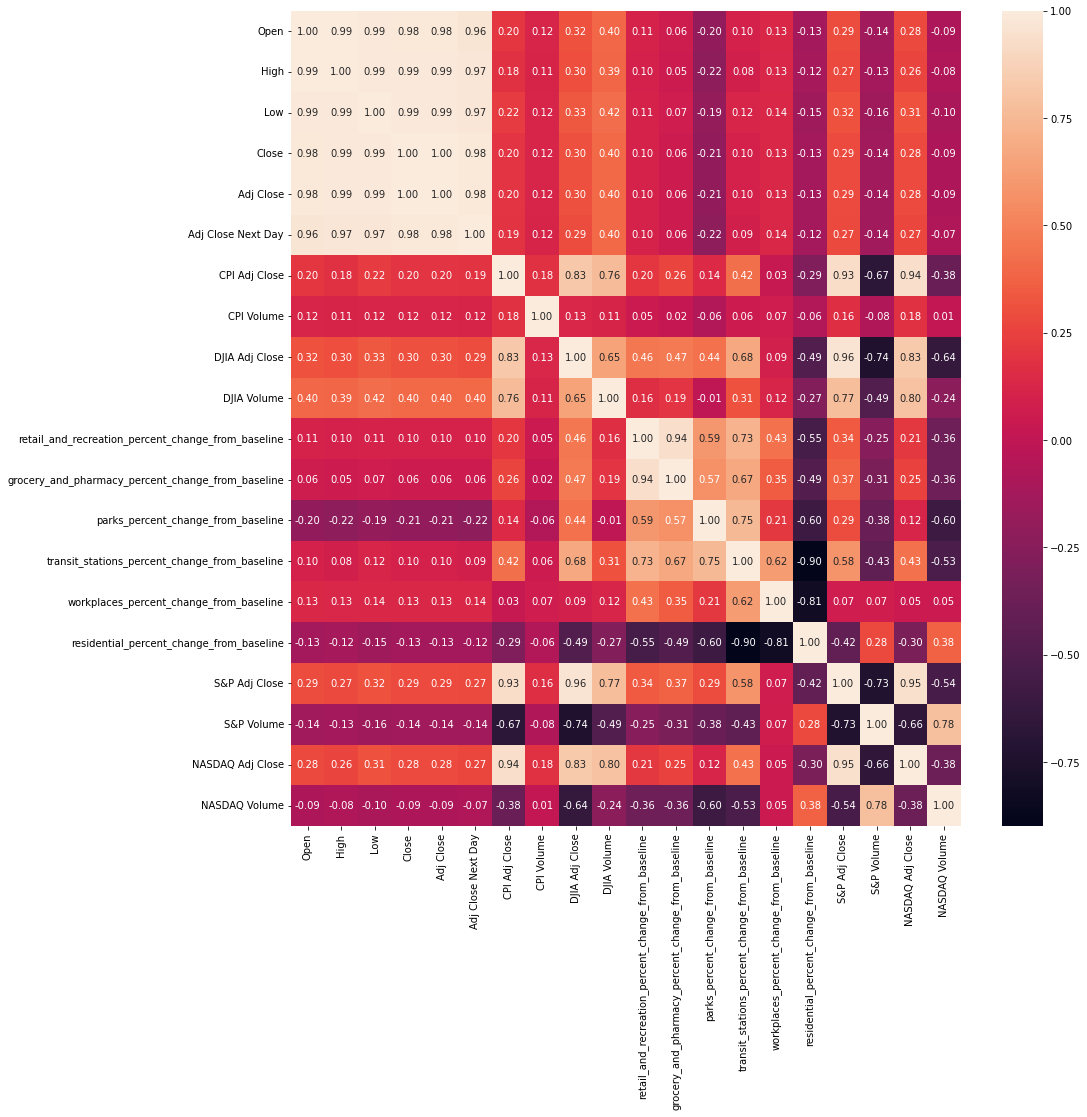

In [26]:
# Now let's check our correlation to 'Adj Close' but first let's remove some redundant columns
df_plot = df_all.drop(['Volume', 'Time Stamp', 'CPI Date', 'CPI Open', 'CPI High', 'CPI Low', 'CPI Close', 'DJIA Date', 'DJIA Open', 'DJIA High', 'DJIA Low', 'DJIA Close', 'country_region_code', 'country_region', 'sub_region_1', 'sub_region_2', 'metro_area', 'iso_3166_2_code', 'census_fips_code', 'place_id', 'date', 'Date_y', 'S&P Date', 'S&P Open', 'S&P High', 'S&P Low', 'S&P Close', 'NASDAQ Date', 'NASDAQ Open', 'NASDAQ High', 'NASDAQ Low', 'NASDAQ Close'], axis=1)
# Increase the heatmap resolution for this many columns
plt.subplots(figsize=(15,15))
sns.heatmap(df_plot.corr(), annot=True, fmt=".2f")

Okay, some positive correlation, but also some negative effects from the following: 

`a.` parks_percent_change_from_baseline: people going to the park or not apparently does not effect Bitcoin value<br>
`b.` residential_percent_change_from_baseline: interesting there is negative correlation since more people are working from home during the pandemic<br>
`c.` S&P Volume: Volume of blue chip trading has no correlation<br>
`d.` NASDAQ Volume: Neither does volume of over the counter trading at the NASDAQ<br>

So let's update our status table...

| No | Indicator | Data Source | Description | Status |
|----|-----------|-------------|-------------|--------|
| 1 | Weekly Unemployment | data/DOL_Weekly_Unemployment_US_2021.csv | I can remember every Thursday when working on Wall Street what a big deal it was when these numbers came out from the US Department of Labor | DONE, no correlation |
| 2 | CPI or Consumer Price Index | data/cpi_index_2021.csv | Indicates strength of consumer market spending, a typical bell weather of consumer confidence | DONE, correlation found |
| 3 | DJIA or Dow Jones Industrial Average Index | data/djia_index_2021.csv | Overall blue chip market indicator | DONE, correlation found |
| 4 | Google Global Mobility Report | data/Global_Mobility_Report_US_2021.csv | How much are people getting around in spite of the COVID-19 global pandemic, filtered down to just US numbers | DONE, some correlation found with the exception of **points a and b** above |
| 5 | SP&500 Index | data/sp500_index_2021.csv | ^GSPC ticker: additional market indicator | DONE, some correlation found with the exception of **point c** above |
| 6 | NASDAQ Composite Index | data/nasdaq_composite_index_2021.csv | ^IXIC ticker: Over the Counter market indicator | DONE, some correlation found with the exception of **point d** above |

...and now I can re-run a new model with this newfound knowledge:

In [27]:
df_all.head()

,Date_x,Open,High,Low,Close,Adj Close,Volume,Adj Close Next Day,Time Stamp,CPI Date,...,S&P Close,S&P Adj Close,S&P Volume,NASDAQ Date,NASDAQ Open,NASDAQ High,NASDAQ Low,NASDAQ Close,NASDAQ Adj Close,NASDAQ Volume
0,2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,32127.267578,2021-01-01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,32782.023438,2021-01-02,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,31971.914062,2021-01-03,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,33992.429688,2021-01-04,2021-01-04,...,3700.649902,3700.649902,5.006680e+09,2021-01-04,12958.519531,12958.719727,12543.240234,12698.450195,12698.450195,6.546740e+09
4,2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,36824.363281,2021-01-05,2021-01-05,...,3726.860107,3726.860107,4.582620e+09,2021-01-05,12665.650391,12828.269531,12665.650391,12818.959961,12818.959961,6.904420e+09


### <a class="anchor" id="Analysis-Data-Exploration-and-Visualization">Part II : Analysis - Data Exploration and Visualization</a>

Now that we have our data in one merged data frame let's begin our analysis. Let us plot our stock price and indicators and see how closely they follow each other.

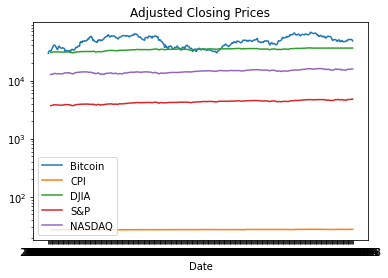

In [28]:
plt.plot(df_all['Date_x'], df_all['Adj Close'], label = 'Bitcoin')
plt.plot(df_all['Date_x'], df_all['CPI Adj Close'], label = 'CPI')
plt.plot(df_all['Date_x'], df_all['DJIA Adj Close'], label = 'DJIA')
plt.plot(df_all['Date_x'], df_all['S&P Adj Close'], label = 'S&P')
plt.plot(df_all['Date_x'], df_all['NASDAQ Adj Close'], label = 'NASDAQ')
plt.xlabel('Date')
plt.legend()
plt.title('Adjusted Closing Prices')
# Plot log values to better see large values on the same plot as smaller values
plt.yscale('log')

Hmmm, are they really as good of Bitcoin price indicators as we originally speculated? Maybe not based on this initial plot? We start to see some linear relationships here. But Bitcoin is definitely more "volatile" compared to the others. Let's analyze this further.

In [29]:
# Initially, we got the classic error: Input contains NaN, infinity or a value too large for dtype('float64')
# So let's get rid of those NaN rows
df_econ = df_all.ffill().bfill()
#Split into explanatory and response variables
X2_econs = df_econ[['Open', 'High', 'Low', 'Close', 'Adj Close', 'CPI Adj Close', 'CPI Volume', 'DJIA Adj Close', 'DJIA Volume', 'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'S&P Adj Close', 'NASDAQ Adj Close']]
y2_econs = df_econ['Adj Close Next Day']

#Split into train and test
X_train2_econs, X_test2_econs, y_train2_econs, y_test2_econs = train_test_split(X2_econs, y2_econs, test_size = .30, random_state=42, shuffle=False) 

lm_econ_model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())
lm_econ_model.fit(X_train2_econs, y_train2_econs)

#Predict and score the model
y_test_preds2_econs = lm_econ_model.predict(X_test2_econs) 

#Rsquared and y_test
rsquared_score_econs = r2_score(y_test2_econs, y_test_preds2_econs)#r2_score
length_y_test_econs = len(y_test2_econs)#num in y_test

print("The Economic r-squared score for our model was {} on {} values.".format(rsquared_score_econs, length_y_test_econs))
print("The Economic is better by {}".format(rsquared_score_econs - rsquared_score_basic))

The Economic r-squared score for our model was 0.9236833182529304 on 109 values.
The Economic is better by -0.040260909601256945


Okay, that is a lot of work wrangling and working with the economic indicator data to now get a r-squared that is 0.004 worse than our basic model. Is there something about crypto currency that defies leading economic indicators and this is an anomoly when compared to more traditional equity stock? Let's try some more traditional stock like a blue chip or better known technlogy stock.

So we pulled down Tesla Motors stock prices...

```
import yfinance as yf  
import matplotlib.pyplot as plt

data = yf.download('TSLA','2021-01-01','2021-12-31')
data = data.reset_index()

data["Close"].plot()
data.to_csv("data/tesla_stock_2021.csv", index=False)

plt.show()
```

and Texas Instruments Inc stock prices for 2021.

```
import yfinance as yf  
import matplotlib.pyplot as plt

data = yf.download('TXN','2021-01-01','2021-12-31')
data = data.reset_index()

data["Close"].plot()
data.to_csv("data/texas_instruments_stock_2021.csv", index=False)

plt.show()
```

Now let's read this data in and compare our models again...

In [30]:
df_tesla = pd.read_csv('data/tesla_stock_2021.csv')
df_ti = pd.read_csv('data/texas_instruments_stock_2021.csv')

duplicates_count = df_tesla.duplicated(subset='Date', keep='first').sum()
assert duplicates_count == 0, "The Tesla duplicate count should be zero, but it is {}".format(duplicates_count)
print("Tesla First day {}, last day {}, total days {}".format(df_tesla.Date.min(), df_tesla.Date.max(), df_tesla.shape[0]))
# In order for merge to work correctly we also have to make sure our 'Date' column is actually a Date value
df_tesla['Date'] = pd.to_datetime(df_tesla['Date'])
# Just the Date part
df_tesla['Date'] = df_tesla['Date'].dt.date
df_tesla['Time Stamp'] = pd.to_datetime(df_tesla['Date'])

duplicates_count = df_ti.duplicated(subset='Date', keep='first').sum()
assert duplicates_count == 0, "The TI duplicate count should be zero, but it is {}".format(duplicates_count)
print("TI First day {}, last day {}, total days {}".format(df_ti.Date.min(), df_ti.Date.max(), df_ti.shape[0]))
# In order for merge to work correctly we also have to make sure our 'Date' column is actually a Date value
df_ti['Date'] = pd.to_datetime(df_ti['Date'])
# Just the Date part
df_ti['Date'] = df_ti['Date'].dt.date
df_ti['Time Stamp'] = pd.to_datetime(df_ti['Date'])

# Create the new Adj Close Next Day column
df_tesla['Adj Close Next Day'] = np.nan
df_ti['Adj Close Next Day'] = np.nan
# For day N we need next day which we don't have (we end currently at 12/28/2021) on the file, so we look it up and plug it in
# from https://finance.yahoo.com/quote/TSLA/history/ 01/03/2022 adjusted closing price 1,167.12
# from https://finance.yahoo.com/quote/TXN/history/ 01/03/2022 adjusted closing price 1,167.12
df_tesla.loc[len(df_tesla) - 1, 'Adj Close Next Day'] = 1167.12
df_ti.loc[len(df_ti) - 1, 'Adj Close Next Day'] = 189.21
# Take next day's Adj Close and put in in the current Adj Close Next Day column
for i in range(0, len(df_tesla) - 1):
    df_tesla.loc[i, 'Adj Close Next Day'] = df_tesla.loc[i+1, 'Adj Close']
for i in range(0, len(df_ti) - 1):
    df_ti.loc[i, 'Adj Close Next Day'] = df_ti.loc[i+1, 'Adj Close']

# And merge all our data
df_all_tesla = df_tesla
df_all_ti = df_ti

df_all_tesla = pd.merge_asof(df_all_tesla, df2cpi, on='Time Stamp')
df_all_ti = pd.merge_asof(df_all_ti, df2cpi, on='Time Stamp')

df_all_tesla = pd.merge_asof(df_all_tesla, df3djia, on='Time Stamp')
df_all_ti = pd.merge_asof(df_all_ti, df3djia, on='Time Stamp')

df_all_tesla = pd.merge_asof(df_all_tesla, df4google, on='Time Stamp')
df_all_ti = pd.merge_asof(df_all_ti, df4google, on='Time Stamp')

df_all_tesla = pd.merge_asof(df_all_tesla, df5snp, on='Time Stamp')
df_all_ti = pd.merge_asof(df_all_ti, df5snp, on='Time Stamp')

df_all_tesla = pd.merge_asof(df_all_tesla, df6nasdaq, on='Time Stamp')
df_all_ti = pd.merge_asof(df_all_ti, df6nasdaq, on='Time Stamp')

Tesla First day 2021-01-04, last day 2021-12-30, total days 251
TI First day 2021-01-04, last day 2021-12-30, total days 251


In [31]:
# Now for our basic models
#Split into explanatory and response variables
X2_basic_tesla = df_all_tesla[['Open', 'High', 'Low', 'Close', 'Adj Close']]
X2_basic_ti = df_all_ti[['Open', 'High', 'Low', 'Close', 'Adj Close']]
y2_basic_tesla = df_all_tesla['Adj Close Next Day']
y2_basic_ti = df_all_ti['Adj Close Next Day']

#Split into train and test
X_train2_basic_tesla, X_test2_basic_tesla, y_train2_basic_tesla, y_test2_basic_tesla = train_test_split(X2_basic_tesla, y2_basic_tesla, test_size = .30, random_state=42, shuffle=False) 
X_train2_basic_ti, X_test2_basic_ti, y_train2_basic_ti, y_test2_basic_ti = train_test_split(X2_basic_ti, y2_basic_ti, test_size = .30, random_state=42, shuffle=False) 

lm_basic_model_tesla = make_pipeline(StandardScaler(with_mean=False), LinearRegression())
lm_basic_model_tesla.fit(X_train2_basic_tesla, y_train2_basic_tesla)

lm_basic_model_ti = make_pipeline(StandardScaler(with_mean=False), LinearRegression())
lm_basic_model_ti.fit(X_train2_basic_ti, y_train2_basic_ti)

#Predict and score the model
y_test_preds2_basic_tesla = lm_basic_model_tesla.predict(X_test2_basic_tesla) 
y_test_preds2_basic_ti = lm_basic_model_ti.predict(X_test2_basic_ti) 

#Rsquared and y_test
rsquared_score_basic_tesla = r2_score(y_test2_basic_tesla, y_test_preds2_basic_tesla)#r2_score
rsquared_score_basic_ti = r2_score(y_test2_basic_ti, y_test_preds2_basic_ti)#r2_score
length_y_test_basic_tesla = len(y_test2_basic_tesla)#num in y_test
length_y_test_basic_ti = len(y_test2_basic_ti)#num in y_test

print("The BASIC r-squared score for our TESLA model was {} on {} values.".format(rsquared_score_basic_tesla, length_y_test_basic_tesla))
print("The BASIC r-squared score for our TI model was {} on {} values.".format(rsquared_score_basic_ti, length_y_test_basic_ti))

The BASIC r-squared score for our TESLA model was 0.9218246494416458 on 76 values.
The BASIC r-squared score for our TI model was 0.4072544954661511 on 76 values.


Now for our economic model comparison...

In [32]:
# Initially, we got the classic error: Input contains NaN, infinity or a value too large for dtype('float64')
# So let's get rid of those NaN rows
df_econ_tesla = df_all_tesla.ffill().bfill()
df_econ_ti = df_all_ti.ffill().bfill()
#Split into explanatory and response variables
X2_econs_tesla = df_econ_tesla[['Open', 'High', 'Low', 'Close', 'Adj Close', 'CPI Adj Close', 'CPI Volume', 'DJIA Adj Close', 'DJIA Volume', 'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'S&P Adj Close', 'NASDAQ Adj Close']]
X2_econs_ti = df_econ_ti[['Open', 'High', 'Low', 'Close', 'Adj Close', 'CPI Adj Close', 'CPI Volume', 'DJIA Adj Close', 'DJIA Volume', 'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'S&P Adj Close', 'NASDAQ Adj Close']]
y2_econs_tesla = df_econ_tesla['Adj Close Next Day']
y2_econs_ti = df_econ_ti['Adj Close Next Day']

#Split into train and test
X_train2_econs_tesla, X_test2_econs_tesla, y_train2_econs_tesla, y_test2_econs_tesla = train_test_split(X2_econs_tesla, y2_econs_tesla, test_size = .30, random_state=42, shuffle=False) 
X_train2_econs_ti, X_test2_econs_ti, y_train2_econs_ti, y_test2_econs_ti = train_test_split(X2_econs_ti, y2_econs_ti, test_size = .30, random_state=42, shuffle=False) 

lm_econ_model_tesla = make_pipeline(StandardScaler(with_mean=False), LinearRegression())
lm_econ_model_ti = make_pipeline(StandardScaler(with_mean=False), LinearRegression())
lm_econ_model_tesla.fit(X_train2_econs_tesla, y_train2_econs_tesla)
lm_econ_model_ti.fit(X_train2_econs_ti, y_train2_econs_ti)

#Predict and score the model
y_test_preds2_econs_tesla = lm_econ_model_tesla.predict(X_test2_econs_tesla) 
y_test_preds2_econs_ti = lm_econ_model_ti.predict(X_test2_econs_ti) 

#Rsquared and y_test
rsquared_score_econs_tesla = r2_score(y_test2_econs_tesla, y_test_preds2_econs_tesla)#r2_score
rsquared_score_econs_ti = r2_score(y_test2_econs_ti, y_test_preds2_econs_ti)#r2_score
length_y_test_econs_tesla = len(y_test2_econs_tesla)#num in y_test
length_y_test_econs_ti = len(y_test2_econs_ti)#num in y_test

print("The Economic TESLA r-squared score for our model was {} on {} values.".format(rsquared_score_econs_tesla, length_y_test_econs_tesla))
print("The Economic TI r-squared score for our model was {} on {} values.".format(rsquared_score_econs_ti, length_y_test_econs_ti))
print("The Economic TESLA is better by {}".format(rsquared_score_econs_tesla - rsquared_score_basic_tesla))
print("The Economic TI is better by {}".format(rsquared_score_econs_ti - rsquared_score_basic_ti))

The Economic TESLA r-squared score for our model was 0.8904456960179603 on 76 values.
The Economic TI r-squared score for our model was 0.3993325049027884 on 76 values.
The Economic TESLA is better by -0.03137895342368546
The Economic TI is better by -0.007921990563362735


Okay, so with less work, no economic indicator data, we can do a better job of predicting future stock value. Now how good is our basic model on real data beyond our initial data?

### <a class="anchor" id="Machine-Learning-Model">Part III: Machine Learning Model</a>

Now that we have our data, let us employ our basic machine learning model to predict future closing prices. We gather additional data from Yahoo! Finance as before:

The basic BTC r-squared score for our model was 0.9341313107858845 on 109 values.


Text(0.5, 1.0, 'Adjusted Closing Prices')

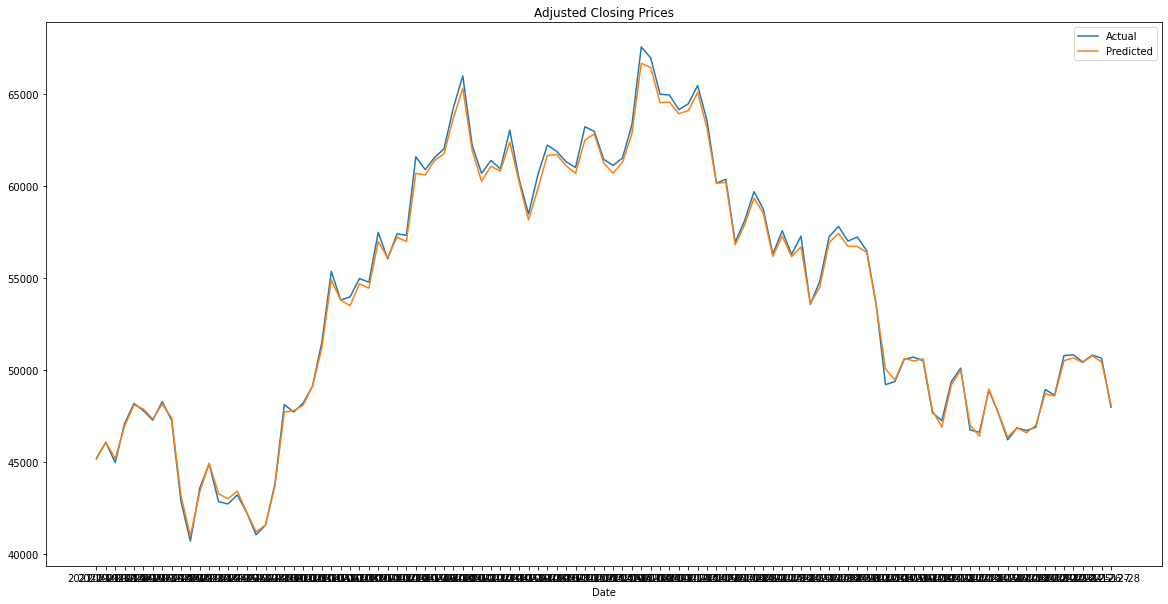

In [33]:
#Split into explanatory and response variables
X2_basic_btc = df_all[['Open', 'High', 'Low', 'Close', 'Adj Close']]
y2_basic_btc = df_all['Adj Close Next Day']

#Split into train and test
X_train2_basic_btc, X_test2_basic_btc, y_train2_basic_btc, y_test2_basic_btc = train_test_split(X2_basic_btc, y2_basic_btc, test_size = .30, random_state=42, shuffle=False) 

lm_basic_btc_model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())
lm_basic_btc_model.fit(X_train2_basic_btc, y_train2_basic_btc)

#Predict and score the model
y_test_preds2_basic_btc = lm_basic_btc_model.predict(X_test2_basic_btc) 

#Rsquared and y_test
rsquared_score_basic_btc = r2_score(y_test2_basic_btc, y_test_preds2_basic_btc)#r2_score
length_y_test_basic_btc = len(y_test2_basic_btc)#num in y_test

print("The basic BTC r-squared score for our model was {} on {} values.".format(rsquared_score_basic_btc, length_y_test_basic_btc))

plt.subplots(figsize=(20,10))
plt.plot(df_all.iloc[X_test2_basic_btc.index]['Date_x'], df_all.iloc[X_test2_basic_btc.index]['Adj Close'], label = 'Actual')
plt.plot(df_all.iloc[X_test2_basic_btc.index]['Date_x'], y_test_preds2_basic_btc, label = 'Predicted')
plt.xlabel('Date')
plt.legend()
plt.title('Adjusted Closing Prices')

From https://finance.yahoo.com/quote/BTC-USD/history:

| Date | Open | High | Low | Close | Adj Close |
|------|------|------|-----|-------|-----------|
|Jan 03, 2022 | 47,284.21 | 47,510.73 | 46,396.58 | 46,651.72 | 46,651.72 | 32,961,656,832
|Jan 02, 2022 | 47,680.93 | 47,881.41 | 46,856.94 | 47,345.22 | 47,345.22 | 27,951,569,547
|Jan 01, 2022 | 46,311.75 | 47,827.31 | 46,288.48 | 47,686.81 | 47,686.81 | 24,582,667,004


In [34]:
# From https://finance.yahoo.com/quote/BTC-USD/history
X2_future_btc = pd.DataFrame(np.array([['2022-01-01', 46311.75, 47827.31, 46288.48, 47686.81, 47686.81], ['2022-01-02', 47680.93, 47881.41, 46856.94, 47345.22, 47345.22]]),
                   columns=['Date_x', 'Open', 'High', 'Low', 'Close', 'Adj Close'])

X_future_btc = X2_future_btc[['Open', 'High', 'Low', 'Close', 'Adj Close']]

# Predict future
y_test_preds_future_btc = lm_basic_btc_model.predict(X_future_btc)
print(y_test_preds_future_btc)
print(X2_future_btc.tail())

date_max = X2_future_btc.iloc[len(X2_future_btc.shape)-1]['Date_x']
pred = pd.to_numeric(y_test_preds_future_btc[0])
actual = pd.to_numeric(X2_future_btc.iloc[len(X2_future_btc.shape)-1]['Adj Close'])
pct = (pred - actual)/actual*100
print("On date {}, we predicted a close of {:,.2f} and it was actually {:,.2f}, off by {:.2f}%".format(date_max, pred, actual, pct))
current = 45886.26
pred2 = pd.to_numeric(y_test_preds_future_btc[1])
print("At the time of this writing the market has not closed for 1/3/2022.\nUSD Bitcoin is currently trading at {:,.2f}.\nWe predict USD Bitcon will close up at {:,.2f}.\n1 share would make ${:,.2f}".format(current, pred2, (pred2 - current)))

[47583.1685969  47449.30090071]
       Date_x      Open      High       Low     Close Adj Close
0  2022-01-01  46311.75  47827.31  46288.48  47686.81  47686.81
1  2022-01-02  47680.93  47881.41  46856.94  47345.22  47345.22
On date 2022-01-02, we predicted a close of 47,583.17 and it was actually 47,345.22, off by 0.50%
At the time of this writing the market has not closed for 1/3/2022.
USD Bitcoin is currently trading at 45,886.26.
We predict USD Bitcon will close up at 47,449.30.
1 share would make $1,563.04


### <a class="anchor" id="The-Stock-Predictor">Part IV: Implementation - The Stock Predictor</a>
Okay, now for the final piece: let us create a function that implements a stock predictor.

This will consist of a training interface that accepts a data range (start_date, end_date) and a list of ticker symbols (e.g. GOOG, AAPL), and builds a model of stock behavior. The code will read the desired historical prices from the Yahoo! Finance data source API.

Then we will create a query interface that accepts a list of dates and a list of ticker symbols, and outputs the predicted stock prices for each of those stocks on the given dates. Note that the query dates passed in must be after the training date range, and ticker symbols must be a subset of the ones trained on.

In [35]:
def is_valid_range(from_date, to_date, can_be_in_the_future = False):
    '''
    INPUT:
    from_date (date) - the starting date range 
    to_date (date) - the ending date range
    can_be_in_the_future (Boolean) - if True the date range may occur beyond today or in the future
    
    OUTPUT:
    error_msg - Optional error message if not valid
    boolean - True if the date range is considered valid, false otherwise
    from_date (Date) - Converted from Date
    to_date (Date) - Converted to Date
    
    Description:
    Given a date range if the dates given are valid, not in the future, and from_date is before to_date
    '''
    # First make sure we have valid dates
    newFromDate = datetime.datetime(1900, 1, 1)
    newToDate = datetime.datetime(1900, 1, 1)

    correctFromDate = isinstance(from_date, datetime.date)
    try:
        if (correctFromDate):
            newFromDate = from_date
        else:
            newFromDate = datetime.datetime.strptime(from_date, '%Y-%m-%d')
            correctFromDate = True
    except:
            correctFromDate = False

    correctToDate = isinstance(to_date, datetime.date)
    try:
        if (correctToDate):
            newToDate = to_date
        else:
            newToDate = datetime.datetime.strptime(to_date, '%Y-%m-%d')
            correctToDate = True
    except:
            correctToDate = False
    
    if (not correctFromDate and not correctToDate):
        return "Invalid from date *and* invalid to date.", False, newFromDate, newToDate
    if (not correctFromDate):
        return "Invalid from date.", False, newFromDate, newToDate
    if (not correctToDate):
        return "Invalid to date.", False, newFromDate, newToDate
    
    if (newToDate <= newFromDate):
       return "Invalid date range, to_date {} must be greater than from_date {}.".format(newToDate, newFromDate), False, newFromDate, newToDate
    
    if (not can_be_in_the_future):
        today = datetime.datetime.today()
        if (newToDate > today):
           return "Invalid date range, to_date {} cannot be in the future or greater than today.".format(newToDate, today.date), False, newFromDate, newToDate
    
    return "", True, newFromDate, newToDate

newFromDate = datetime.datetime(1900, 1, 1)
newToDate = datetime.datetime(1900, 1, 1)

error_msg, bool_val, newFromDate, newToDate = is_valid_range(None, None)
assert error_msg == "Invalid from date *and* invalid to date.", "Invalid date range did not return expected error msg: {}".format(error_msg)
error_msg, bool_val, newFromDate, newToDate = is_valid_range(None, '2021-04-19')
assert error_msg == "Invalid from date.", "Invalid date range did not return expected error msg: {}".format(error_msg)
error_msg, bool_val, newFromDate, newToDate = is_valid_range('2021-04-19', None)
assert error_msg == "Invalid to date.", "Invalid date range did not return expected error msg: {}".format(error_msg)
error_msg, bool_val, newFromDate, newToDate = is_valid_range('2021-04-19', '2021-04-19')
assert error_msg == "Invalid date range, to_date 2021-04-19 00:00:00 must be greater than from_date 2021-04-19 00:00:00.", "Invalid date range did not return expected error msg: {}".format(error_msg)
error_msg, bool_val, newFromDate, newToDate = is_valid_range('2021-04-19', '2020-12-11')
assert error_msg == "Invalid date range, to_date 2020-12-11 00:00:00 must be greater than from_date 2021-04-19 00:00:00.", "Invalid date range did not return expected error msg: {}".format(error_msg)
error_msg, bool_val, newFromDate, newToDate = is_valid_range('2021-04-19', '9999-04-19')
assert error_msg == "Invalid date range, to_date 9999-04-19 00:00:00 cannot be in the future or greater than today.", "Invalid date range did not return expected error msg: {}".format(error_msg)
error_msg, bool_val, newFromDate, newToDate = is_valid_range('2021-04-19', '9999-04-19', True)
assert bool_val, "Valid future date range did not return expected True boolean, instead got {} and error msg: {}".format(bool_val, error_msg)
print("All is_valid_range tests passed. Good.")

All is_valid_range tests passed. Good.


In [36]:
# In order to minimize calls to the API we will cache or store calls per day per symbol, 
# meaning we will only call the API once per day per stock symbol
stock_hash = {}

In [37]:
def get_from_cache(symbol, from_date, to_date):
    '''
    INPUT:
    symbol - Input stock ticker to get historical data for
    from_date - (date) the starting date range to get data for 
    to_date - (date) the ending date range to get data for 
    
    OUTPUT:
    error_msg (str) - Optional error message when applicable, if empty the data frame is valid
    bool_val (Boolean) - If True then we found a valid DataFrame in our cache for the given parameters
    df_ret (Pandas DataFrame) - DataFrame containing columns Date, Open, High, Low, Close, and Adj Close
    
    Description:
    Given a valid stock symbol ticker and date range, check if we have already cached 
    this information and if so return it. We have refactored this function because 
    we may use a database to cache this in the future, but for now are caching using a
    dictionary: stock_hash
    '''
    # Initialize empy data frame to return by default
    df_ret = pd.DataFrame()
    
    # Get today's date because we need to check our cache first
    today = datetime.datetime.today().strftime('%Y-%m-%d')
    key = today + "|" + symbol
    
    # Check if stock_hash already has this. If the data frame cached is None the set the appropriate error message
    if key in stock_hash.keys():
        df_ret = stock_hash[key]
        if (len(df_ret) == 0):
            return "Invalid symbol '{}' passed.".format(symbol), True, df_ret
        # Even if we have this symbol in our cache for today make sure the date range is within our cached date range
        if ((from_date < df_ret.Date.min()) or (to_date > df_ret.Date.max())):
            return "Cached dates [{} to {}] outside the given range [{} to {}]".format(df_ret.Date.min(), df_ret.Date.max(), from_date, to_date), True, df_ret
        return "", True, df_ret[(df_ret['Date'] >= from_date) & (df_ret['Date'] <= to_date)]
    return "", False, df_ret

error_msg, bool_val, df_ret = get_from_cache('XXX', datetime.datetime(2021, 4, 19), datetime.datetime(9999, 4, 19))
assert not bool_val, "Did not expect for this to be in cache: {}".format(error_msg)

key1 = datetime.datetime.today().strftime('%Y-%m-%d') + "|ABC123"
if key1 in stock_hash.keys():
    del stock_hash[key1]
stock_hash[key1] = pd.DataFrame()

error_msg, bool_val, df_ret = get_from_cache('ABC123', datetime.datetime(2021, 4, 19), datetime.datetime(9999, 4, 19))
assert bool_val and error_msg == "Invalid symbol 'ABC123' passed.", "Expected 'ABC123' to be in cache but got back unexpected: {} and {}".format(bool_val, error_msg)
if key1 in stock_hash.keys():
    del stock_hash[key1]

key2 = datetime.datetime.today().strftime('%Y-%m-%d') + "|ABC456"
if key2 in stock_hash.keys():
    del stock_hash[key2]
stock_hash[key2] = pd.DataFrame({'Date': [datetime.datetime(2021, 4, 18), datetime.datetime(2021, 4, 19)]})

error_msg, bool_val, df_ret = get_from_cache('ABC456', datetime.datetime(2021, 4, 19), datetime.datetime(2022, 4, 19))
assert bool_val and error_msg == "Cached dates [2021-04-18 00:00:00 to 2021-04-19 00:00:00] outside the given range [2021-04-19 00:00:00 to 2022-04-19 00:00:00]", "Expected 'ABC456' to be in cache but got: {} and {}".format(bool_val, error_msg)
if key2 in stock_hash.keys():
    del stock_hash[key2]

print("All get_from_cache tests passed. Good.")

All get_from_cache tests passed. Good.


In [38]:
def get_stock_history(symbol, from_date, to_date):
    '''
    INPUT:
    symbol - Input stock ticker to get historical data for
    from_date - (date) the starting date range to get data for 
    to_date - (date) the ending date range to get data for 
    
    OUTPUT:
    error_msg - Optional error message when applicable, if empty the data frame is valid
    df - Pandas data frame containing columns Date, Open, High, Low, Close, Adj Close
    
    Description:
    Given a valid stock symbol ticker and date range, check if we have already cached 
    this information in the stock_hash dictionary, if not, call the Yahoo! Finance API
    to get this data, cached it, and return the results.
    '''
    # First make sure we have a valid ticker string
    if (not symbol):
        return "Invalid symbol string passed.", pd.DataFrame()
    
    # Now check for a valid date range
    error_msg, bool_val, from_date, to_date = is_valid_range(from_date, to_date)
    if (not bool_val):
        return error_msg, None
    
    # See if we already have this in our cache
    error_msg, bool_val, df_ret = get_from_cache(symbol, from_date, to_date)
    if (bool_val):
        return error_msg, df_ret
    
    # Call the API: Yahoo! Finance is not inclusive of the date ranges to subtract and add one day accordingly
    df_ret = yf.download(symbol, from_date + datetime.timedelta(days=-1), to_date + datetime.timedelta(days=1))
    df_ret = df_ret.reset_index()

    if (len(df_ret) == 0):
        error_msg = "Invalid symbol '{}' passed.".format(symbol)
    
    # Get today's date because we need to check our cache first
    today = datetime.datetime.today().strftime('%Y-%m-%d')
    key = today + "|" + symbol
    
    # Store it in the hash for next time we call it
    if key in stock_hash.keys():
        del stock_hash[key]
    stock_hash[key] = df_ret

    return error_msg, df_ret

error_msg, df_ret = get_stock_history('ZVZZT', '2021-04-19', '9999-04-19')
assert error_msg == "Invalid date range, to_date 9999-04-19 00:00:00 cannot be in the future or greater than today.", "Invalid date range did not return expected error msg: {}".format(error_msg)
error_msg, df_ret = get_stock_history('ZVZZT', '2021-01-01', '2021-12-31')
assert len(df_ret) == 0, "Did not expect ZVZZT to be a valid symbol with data"
error_msg, df_ret = get_stock_history('TSLA', '2021-01-01', '2021-12-31')
assert len(df_ret) > 0, "Expected TSLA to be a valid symbol with data"
error_msg, df_ret = get_stock_history('TSLA', '2021-01-01', '2021-10-30')
assert len(df_ret) > 0 and (pd.Timestamp(df_ret.tail(1)['Date'].values[0]) <= pd.Timestamp(datetime.datetime(2021, 10, 30))), "Expected TSLA to be a valid symbol with data, but last date outside of expected end date 2021-10-30: {}".format(df_ret.tail(1)['Date'].values)
print("All get_stock_history tests passed. Good.")
df_ret.tail()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ZVZZT: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
All get_stock_history tests passed. Good.


,Date,Open,High,Low,Close,Adj Close,Volume
205,2021-10-25,950.530029,1045.020020,944.200012,1024.859985,1024.859985,62852100
206,2021-10-26,1024.689941,1094.939941,1001.440002,1018.429993,1018.429993,62415000
207,2021-10-27,1039.660034,1070.880005,1030.780029,1037.859985,1037.859985,38526500
208,2021-10-28,1068.310059,1081.000000,1054.199951,1077.040039,1077.040039,27213200
209,2021-10-29,1081.859985,1115.209961,1073.209961,1114.000000,1114.000000,29918400


### Implement Stock Predictor
Now that we have our helper functions coded and tested above, we can create our final two functions to first train a set of stock symbols and date ranges as well as then make predictions.

Notice class `TrainedModelLinear` is being used to not only encapsulate linear model functionality, but all the different linear models we have to associate to a symbol. This is because the Open/High/Low/Close/Adj Close are all inputs we need to predict them all to project out prices into the future. In other words, it is not enough to predict the Adj Close price and put it in the Adj Close Next Day column, but also to predict the other N+1 values that will go into the model to predict Adj Close for N+2, etc. Another advantage to encapsulate the functionality into one class like this is that we can more easily switch out the model for something other than a Linear Based model (y = mX + B). In fact, we could create a base abstract class called class `TrainedModel` that defines abstract methods `fit` and `predict` and we can swap out any model and compare results.

#### Metrics: Model Performance
In terms of the **Metrics** selected for measuring performance notice we have also have a function called `evaluate_model` which calculates R-squared. This of course being the traditional statistical measure to represent the goodness of the linear fit of the model, with the ideal value being 1. But because I am predicting financial calculations I also borrowed from this article ["Stock Prediction using Regression Algorithm in Python"](https://medium.com/codex/stock-predication-using-regression-algorithm-in-python-fb8b426453b9) by Abdalla A. Mahgoub, the following additional metrics:

`1.` Accuracy: based on the mean ratios of actual prices over predicted prices<br>
`2.` Mean Absolute Error (MAE): measures the average magnitude of the errors in a set of predictions, without considering their direction<br>
![MAE Formula](https://miro.medium.com/max/406/0*OgNQXZ3juR5lPm2W.jpg)
`3.` Mean Squared Error (MSE): quadratic scoring rule that also measures the average magnitude of the error<br>
![MSE Formula](https://miro.medium.com/max/447/0*XKakid1rOSZRRyDm.jpg)
`4.` Root Mean Squared Error (RMSE): measures the average of the squares of the errors, the average squared difference between the estimated values and the actual value.<br>
![RMSE Formula](https://miro.medium.com/max/431/0*owl-1PIXE9bMYhVw.jpg)

>> All mentioned metrics above can range from 0 to ∞ and are indifferent to the direction of errors. They are negatively-oriented scores, which means the lower values they present the better. Remember that RMSE will always be larger in value than MSE, Also it can penalize more error-related data so RMSE can be a better measure than MSE.

In [106]:
# In order for get_stock_predictions to use the model trained by get_stock_histories we will have to cache these 
# trained models here per stock symbol. Since we need both the model itself plus the dates for which it was trained 
# we will also create a class that encapsulates these concepts into one object that we cache by symbol.
model_hash = {}

# Using a base class so we can swap out our model if we need to
class TrainedModel:
    """
    A base class to encapsulate a trained model that uses any implemented algo and the date range for which it was trained.

    ...

    Attributes
    ----------
    model : sklearn.pipeline.Pipeline
        the trained model
    from_date : date
        beginning date range
    to_date : date
        ending date range
    """
    def __init__(self, symbol, df, from_date, to_date):
        """
        Constructs all the necessary attributes for the base TrainedModel object.

        Parameters
        ----------
            symbol : str
                The stock ticker symbol, e.g. GOOGL, MSFT, etc.
            df : Pandas DataFrame
                The underlying historical DataFrame
            from_date : Date
                beginning date range
            to_date : Date
                ending date range
        """
        self.name = ""
        self.symbol = symbol
        self.df = df
        if ('Date' in df.columns):
            self.df = df.sort_values(by=['Date'])
        self.modelAdjCloseNextDay = None
        self.modelOpen = None
        self.modelHigh = None
        self.modelLow = None
        self.modelClose = None
        self.from_date = from_date
        self.to_date = to_date
        # For now set to end date and empty test data frames, but this will be updated after function fit runs
        self.last_trained_date = to_date
        self.X_testAdjCloseNextDay = pd.DataFrame()
        self.y_testAdjCloseNextDay = pd.DataFrame()
    
    def fit(self, test_size, random_state):
        """
        Fits the inputs using TrainedModel model, otherwise known as training the model.

        Parameters
        ----------
            test_size : numeric
                How much of the training data gets set aside for test data
            random_state : numeric
                Numeric that allows us to repeat a "random value"
        """
        raise ValueError("*** ERROR: Class {} does not implement fit method.", self.name)

    def predict(self, current_date, df_curr):
        """
        Make the prediction for the given current_date using the TrainedModel object.
        We account for scenarios where tests are run for data within the range of our test data, 
        meaning we have the reported Open, High, Low, Close, Adj Close already, *or* the case 
        where we are asked to predict beyond our test data.

        Parameters
        ----------
            current_date : Date
                The date being predicted
            df_curr : Pandas DataFrame
                The DataFrame containing the inputs for the previous date used to predict current_date data
                
        Returns
        -------
            df_next : Pandas DataFrame
                Resulting DataFrame containing current_date predictions
        """
        raise ValueError("*** ERROR: Class {} does not implement predict method.", self.name)
    
    def evaluate_model(self, X_test = pd.DataFrame(), Y_test = pd.DataFrame()):
        """
        Evaluates the given model with the given X test data and expected Y test data
        Parameters
        ----------
        X_test: pandas.Series
            Optional X input test data, if not given use the test data we have self.X_testAdjCloseNextDay
        Y_test: pandas.Series
            Optional Y output test data, if not given use the test data we have self.y_testAdjCloseNextDay
        Returns
        -------
        None
        Examples
        --------
        >>> evaluate_model()
        >>> evaluate_model(X_test, Y_test)

        """
        raise ValueError("*** ERROR: Class {} does not implement evaluate_model method.", self.name)
    
    def evaluate_modelcv(self, cv, X_test = pd.DataFrame(), Y_test = pd.DataFrame()):
        """
        Eevaluate the model using a given test condition cv
        Parameters
        ----------
        cv: test condition
        X_test: pandas.Series
            Optional X input test data, if not given use the test data we have self.X_testAdjCloseNextDay
        Y_test: pandas.Series
            Optional Y output test data, if not given use the test data we have self.y_testAdjCloseNextDay
        Returns
        -------
        None
        Examples
        --------
        >>> evaluate_modelcv(cv)
        >>> evaluate_modelcv(cv, X_test, Y_test)

        """
        raise ValueError("*** ERROR: Class {} does not implement evaluate_modelcv method.", self.name)


In [248]:
# In order for get_stock_predictions to use the model trained by get_stock_histories we will have to cache these 
# trained models here per stock symbol. Since we need both the model itself plus the dates for which it was trained 
# we will also create a class that encapsulates these concepts into one object that we cache by symbol.
model_hash = {}

class TrainedModelLinear(TrainedModel):
    """
    A class to encapsulate a trained model that uses Linear Regression and the date range for which it was trained.

    ...

    Attributes
    ----------
    model : sklearn.pipeline.Pipeline
        the trained model
    from_date : date
        beginning date range
    to_date : date
        ending date range
    """
    def __init__(self, symbol, df, from_date, to_date):
        """
        Constructs all the necessary attributes for the TrainedModelLinear object.

        Parameters
        ----------
            symbol : str
                The stock ticker symbol, e.g. GOOGL, MSFT, etc.
            df : Pandas DataFrame
                The underlying historical DataFrame
            from_date : Date
                beginning date range
            to_date : Date
                ending date range
        """
        self.symbol = symbol
        self.df = df
        if ('Date' in df.columns):
            self.df = df.sort_values(by=['Date'])
        self.modelAdjCloseNextDay = make_pipeline(StandardScaler(with_mean=False), LinearRegression())
        self.modelOpen = make_pipeline(StandardScaler(with_mean=False), LinearRegression())
        self.modelHigh = make_pipeline(StandardScaler(with_mean=False), LinearRegression())
        self.modelLow = make_pipeline(StandardScaler(with_mean=False), LinearRegression())
        self.modelClose = make_pipeline(StandardScaler(with_mean=False), LinearRegression())
        self.from_date = from_date
        self.to_date = to_date
        # For now set to end date and empty test data frames, but this will be updated after function fit runs
        self.last_trained_date = to_date
        self.X_testAdjCloseNextDay = pd.DataFrame()
        self.y_testAdjCloseNextDay = pd.DataFrame()
    
    def fit(self, test_size, random_state):
        """
        Fits the inputs using TrainedModelLinear model, otherwise known as training the model. Initially we started 
        using train_test_split to split our training and test data but then realized we did not want to split it
        randomly but rather in order since we want to train with most of the data and we want to track what the 
        last N Date is we trained for when we start testing the effectiveness of the model.

        Parameters
        ----------
            test_size : numeric
                How much of the training data gets set aside for test data
            random_state : numeric
                Numeric that allows us to repeat a "random value"
        """
        # Set the last_trained_date based on the test_size index - 1
        if test_size >= 1:
            self.last_trained_date = self.df.loc[self.df.tail(test_size).index - 1, 'Date'].values[0]
            self.last_trained_date = datetime.datetime.strptime(np.datetime_as_string(self.last_trained_date,unit='D'), '%Y-%m-%d')

        #Split into explanatory and response variables for Adj Close Next Day
        X2_AdjCloseNextDay = self.df[['Open', 'High', 'Low', 'Close', 'Adj Close']]
        y2_AdjCloseNextDay = self.df['Adj Close Next Day']
        
        #Split into train and test, then fit the model for Adj Close Next Day
        self.X_trainAdjCloseNextDay, self.X_testAdjCloseNextDay, self.y_trainAdjCloseNextDay, self.y_testAdjCloseNextDay = train_test_split(X2_AdjCloseNextDay, y2_AdjCloseNextDay, test_size = test_size, random_state = random_state, shuffle=False)

        if test_size < 1:
            self.last_trained_date = self.df.at[self.X_trainAdjCloseNextDay.index.max(), 'Date']
            
        ##print("self.last_trained_date: {}, self.X_testAdjCloseNextDay: {}".format(self.last_trained_date, self.X_testAdjCloseNextDay.tail()))

        # Format last trained date from numpy 64 datetime to python datetime
        ##self.last_trained_date = datetime.datetime.strptime(np.datetime_as_string(self.last_trained_date,unit='D'), '%Y-%m-%d')

        # Save test data for optional call to function evaluate model
        ##self.X_testAdjCloseNextDay = self.X2_AdjCloseNextDay.tail(last_date_test_size)
        ##self.y_testAdjCloseNextDay = self.y2_AdjCloseNextDay.tail(last_date_test_size)
        
        # Run the model fit for Adj Close Next Day
        self.modelAdjCloseNextDay.fit(self.X_trainAdjCloseNextDay, self.y_trainAdjCloseNextDay)

        #Split into explanatory and response variables for Open
        X2_Open = self.df[['High', 'Low', 'Close', 'Adj Close']]
        y2_Open = self.df['Open']

        #Split into train and test, then fit the model for Open
        X_trainOpen, X_testOpen, y_trainOpen, y_testOpen = train_test_split(X2_Open, y2_Open, test_size = test_size, random_state = random_state, shuffle=False)
        ##X_trainOpen = X2_Open.drop(X2_Open.tail(test_size).index)
        ##y_trainOpen = y2_Open.drop(y2_Open.tail(test_size).index)
        self.modelOpen.fit(X_trainOpen, y_trainOpen)

        #Split into explanatory and response variables for High
        X2_High = self.df[['Open', 'Low', 'Close', 'Adj Close']]
        y2_High = self.df['High']

        #Split into train and test, then fit the model for High
        X_trainHigh, X_testHigh, y_trainHigh, y_testHigh = train_test_split(X2_High, y2_High, test_size = test_size, random_state = random_state, shuffle=False)
        ##X_trainHigh = X2_High.drop(X2_High.tail(test_size).index)
        ##y_trainHigh = y2_High.drop(y2_High.tail(test_size).index)
        self.modelHigh.fit(X_trainHigh, y_trainHigh)

        #Split into explanatory and response variables for Low
        X2_Low = self.df[['Open', 'High', 'Close', 'Adj Close']]
        y2_Low = self.df['Low']

        #Split into train and test, then fit the model for Low
        X_trainLow, X_testLow, y_trainLow, y_testLow = train_test_split(X2_Low, y2_Low, test_size = test_size, random_state = random_state, shuffle=False)
        ##X_trainLow = X2_Low.drop(X2_Low.tail(test_size).index)
        ##y_trainLow = y2_Low.drop(y2_Low.tail(test_size).index)
        self.modelLow.fit(X_trainLow, y_trainLow)

        #Split into explanatory and response variables for Close
        X2_Close = self.df[['Open', 'High', 'Low', 'Adj Close']]
        y2_Close = self.df['Close']

        #Split into train and test, then fit the model for Close
        X_trainClose, X_testClose, y_trainClose, y_testClose = train_test_split(X2_Close, y2_Close, test_size = test_size, random_state = random_state, shuffle=False)
        ##X_trainClose = X2_Close.drop(X2_Close.tail(test_size).index)
        ##y_trainClose = y2_Close.drop(y2_Close.tail(test_size).index)
        self.modelClose.fit(X_trainClose, y_trainClose)

    def predict(self, current_date, df_curr):
        """
        Make the prediction for the given current_date using the TrainedModelLinear object.
        We account for scenarios where tests are run for data within the range of our test data, 
        meaning we have the reported Open, High, Low, Close, Adj Close already, *or* the case 
        where we are asked to predict beyond our test data.

        Parameters
        ----------
            current_date : Date
                The date being predicted
            df_curr : Pandas DataFrame
                The DataFrame containing the inputs for the previous date used to predict current_date data
                
        Returns
        -------
            df_next : Pandas DataFrame
                Resulting DataFrame containing current_date predictions
        """

        # Handle the case where the date we want to predict falls outside of our test data so 
        # we have to predict the Open, High, Low, Close, Adj Close for the date in question
        # in order to set up current_date + 1 data, otherwise, we can simply use the existing
        # test data values to predict current_date + 1
        if (current_date > self.to_date):
            # Get the inputs we need to make our prediction
            df_next = df_curr.tail(1).copy()

            X_AdjCloseNextDay = df_next[['Open', 'High', 'Low', 'Close', 'Adj Close']]
            y_AdjCloseNextDay = self.modelAdjCloseNextDay.predict(X_AdjCloseNextDay)
            
            # Set previous day Adj Close Next Day
            df_next.iloc[-1, df_curr.columns.get_loc('Adj Close Next Day')] = y_AdjCloseNextDay[0]
            
            # Now predict all of our indicators which will be used when predicting since in this case
            # current_date is beyond the size of our existing dataset which ends on self.to_date
            X_Open = df_next[[ 'High', 'Low', 'Close', 'Adj Close']]
            y_Open = self.modelOpen.predict(X_Open)

            X_High = df_next[['Open', 'Low', 'Close', 'Adj Close']]
            y_High = self.modelHigh.predict(X_High)

            X_Low = df_next[['Open', 'High', 'Close', 'Adj Close']]
            y_Low = self.modelLow.predict(X_Low)

            X_Close = df_next[['Open', 'High', 'Low', 'Adj Close']]
            y_Close = self.modelClose.predict(X_Close)

            # Add our new record for current_date that uses all of our predicted data
            # Notice we don't fill in Adj Close Next Day as that gets set when you run 
            # for current_date + 1
            df_ret = df_next.append({'Symbol': self.symbol, 'Date': current_date, 'Open': y_Open[0], 'High': y_High[0], 'Low': y_Low[0], 'Close': y_Close[0], 'Adj Close': y_AdjCloseNextDay[0], 'Adj Close Next Day': np.nan}, ignore_index=True)
        else:
            df_ret = self.df[self.df['Date'] == current_date].copy()
            # Get the inputs we need to make our prediction
            df_next = df_curr.tail(1).copy()

            X_AdjCloseNextDay = df_next[['Open', 'High', 'Low', 'Close', 'Adj Close']]
            y_AdjCloseNextDay = self.modelAdjCloseNextDay.predict(X_AdjCloseNextDay)
            # Set previous day Adj Close Next Day
            df_ret.iloc[:, df_ret.columns.get_loc('Adj Close Next Day')] = y_AdjCloseNextDay[0]
            
        return df_ret
    
    def evaluate_model(self, X_test = pd.DataFrame(), Y_test = pd.DataFrame()):
        """
        Evaluates the given model with the given X test data and expected Y test data
        Parameters
        ----------
        X_test: pandas.Series
            Optional X input test data, if not given use the test data we have self.X_testAdjCloseNextDay
        Y_test: pandas.Series
            Optional Y output test data, if not given use the test data we have self.y_testAdjCloseNextDay
        Returns
        -------
        None
        Examples
        --------
        >>> evaluate_model()
        >>> evaluate_model(X_test, Y_test)

        """
        # Use our object test values if none given
        if X_test.shape[0] == 0:
            X_test = self.X_testAdjCloseNextDay
        if Y_test.shape[0] == 0:
            Y_test = self.y_testAdjCloseNextDay
        
        # run the model predictions to evaluate performance
        y_pred = self.modelAdjCloseNextDay.predict(X_test)
        #Rsquared and y_test
        length_y_test = len(Y_test)#num in Y_test

        if (length_y_test < 2):
            print("    The r-squared score of the model is NOT calculated for sample size less than 2: {} value(s).".format(length_y_test))
        else:
            rsquared_score = r2_score(Y_test, y_pred)#r2_score
            print("    The r-squared score of the model {:.2f} on {} values.".format(rsquared_score, length_y_test))
       
        actuals = Y_test
        predicted = y_pred
        plt.scatter(actuals, predicted,  color='Darkblue')
        plt.xlabel("Actual Price")
        plt.ylabel("Predicted Price")
        plt.show()
        x2 = actuals.mean()
        y2 = predicted.mean()
        accuracy = x2/y2*100
        print("    The accuracy of the model is: {:.2f}".format(accuracy))
        print("    Mean Absolute Error (MAE): {:.2f}".format(metrics.mean_absolute_error(actuals, predicted)))
        print("    Mean Squared Error (MSE) : {:.2f}".format(metrics.mean_squared_error(actuals, predicted)))
        print("    Root Mean Squared Error (RMSE): {:.2f}".format(np.sqrt(metrics.mean_squared_error(actuals, predicted))))
    
    def evaluate_modelcv(self, cv, X_test = pd.DataFrame(), Y_test = pd.DataFrame()):
        """
        Eevaluate the model using a given test condition cv
        Parameters
        ----------
        cv: test condition
        X_test: pandas.Series
            Optional X input test data, if not given use the test data we have self.X_testAdjCloseNextDay
        Y_test: pandas.Series
            Optional Y output test data, if not given use the test data we have self.y_testAdjCloseNextDay
        Returns
        -------
        Scores
        Examples
        --------
        >>> ideal, _, _ = a_model.evaluate_modelcv(LeaveOneOut())
        >>> print('Ideal: %.3f' % ideal)
        """
        # Use our object test values if none given
        if len(X_test) == 0:
            X_test = self.X_testAdjCloseNextDay
        if len(Y_test) == 0:
            Y_test = self.y_testAdjCloseNextDay
        # evaluate the model
        ##print ("cross_val_score: X_test:\n{}\nY_test:\n{}\n".format(X_test.tail(), Y_test.tail()))
        # For evaluating multiple scores, we use sklearn.model_selection.cross_validate instead of cross_val_score
        # The following return nan's so leaving these out: 'test_neg_mean_absolute_error', 'test_neg_root_mean_squared_error', 'test_r2', and 'test_accuracy'
        # Including only these: 'fit_time' and 'score_time'
        scorers = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']
        scores = cross_validate(self.modelAdjCloseNextDay, X_test, Y_test, scoring=scorers, cv=cv, n_jobs=-1)
        print("cross_validate scores: {}".format(scores))
        # return scores
        return np.mean(scores['test_r2']), scores['test_r2'].min(), scores['test_r2'].max()
    
a_model = TrainedModelLinear('ZVZZT', pd.DataFrame(), '2021-01-01', '2021-12-31')
assert a_model.symbol == 'ZVZZT', "Did not get expected symbol, instead got: {}".format(a_model.symbol)
print("All TrainedModelLinear class tests passed. Good.")

All TrainedModelLinear class tests passed. Good.


In [249]:
def GetTrainedModel(symbol, df_symbol, newFromDate, newToDate):
    '''
    INPUT:
    symbol (str) - The stock ticker to get historical data for
    df_symbol (str) - The underlying Pandas DataFrame of train and test data
    newFromDate (date) - The starting date range to get data for 
    newToDate (date) - The ending date range to get data for 
    
    OUTPUT:
    model (TrainedModel) - The model of choice for our tests
    
    Description:
    This function determines which child class TrainedModel to use for our tests
    '''
    return TrainedModelLinear(symbol, df_symbol, newFromDate, newToDate)

In [250]:
def get_stock_histories(from_date, to_date, symbols, test_size = 0.3, random_state = 42):
    '''
    INPUT:
    from_date (date) - The starting date range to get data for 
    to_date (date) - The ending date range to get data for 
    symbols (array) - List of stock tickers to get historical data for
    test_size (numeric) - Optional test size, can be a float in the (0, 1) range to indicate a percentage like .01 = 1%, 
                          or a number that is at least 1 but less than the total size. 
                          We default to 1 because we want to train with most of the data.
    random_state (numeric) - Optional random state
    
    OUTPUT:
    error_msg (str) - Optional error message when applicable, if empty the data frame is valid
    bool_ret (Boolean) - If True then the function ran successfully, else the error is contained in error_msg
    
    Description:
    This is the training interface function that accepts a data range (start_date, end_date) and 
    a list of ticker symbols (e.g. GOOG, AAPL), and builds a model of stock behavior. 
    The code will read the desired historical prices from the Yahoo! Finance data source API, if not cached already.
    '''
    # First make sure we have a valid ticker list
    if (not symbols or len(symbols) == 0):
        return "Error: invalid or empty list of symbols passed.", False
    # For each symbol train and cache a model
    for symbol in symbols:
        error_msg, df_ret = get_stock_history(symbol, from_date, to_date)
        if (len(error_msg) > 0 or len(df_ret) == 0):
            return error_msg, False
        # call this to get valid date objects newFromDate, newToDate
        error_msg, bool_val, newFromDate, newToDate = is_valid_range(from_date, to_date)
        # Add column Adj Close Next Day
        df_symbol = df_ret.copy()
        df_symbol['Adj Close Next Day'] = np.nan
        # Add Symbol column first
        df_symbol.insert(0, 'Symbol', symbol)
        # Take next day's Adj Close and put in in the current Adj Close Next Day column
        for i in range(1, len(df_symbol) - 1):
            df_symbol.loc[i, 'Adj Close Next Day'] = df_symbol.loc[i+1, 'Adj Close']
        # Backfill the nth day
        df_symbol = df_symbol.ffill().bfill()

        lm_symbol_model = GetTrainedModel(symbol, df_symbol, newFromDate, newToDate)
        lm_symbol_model.fit(test_size, random_state)
        
        model_hash[symbol] = lm_symbol_model
        
    return "", True

error_msg, bool_ret = get_stock_histories('2021-01-01', '2021-12-31', [])
assert not bool_ret and error_msg == "Error: invalid or empty list of symbols passed.", "Did not get expected False and message, instead got: {} and {}".format(bool_ret, error_msg)
error_msg, bool_ret = get_stock_histories('2021-01-01', '2021-12-31', ['ZVZZT', 'YHOO'])
assert not bool_ret and error_msg == "Invalid symbol 'ZVZZT' passed.", "Did not get expected False and message, instead got: {} and {}".format(bool_ret, error_msg)
error_msg, bool_ret = get_stock_histories('2021-01-01', '2021-12-31', ['TSLA', 'AAPL', 'MSFT'])
assert bool_ret and len(error_msg) == 0, "Did not get expected True and empty message, instead got: {} and {}".format(bool_ret, error_msg)
print("All get_stock_histories tests passed. Good.")
model_hash

All get_stock_histories tests passed. Good.


{'TSLA': <__main__.TrainedModelLinear at 0x1d838bdc910>,
 'AAPL': <__main__.TrainedModelLinear at 0x1d837979b50>,
 'MSFT': <__main__.TrainedModelLinear at 0x1d8374b5940>}

*** Symbol: TSLA

    The r-squared score of the model 0.93 on 76 values.


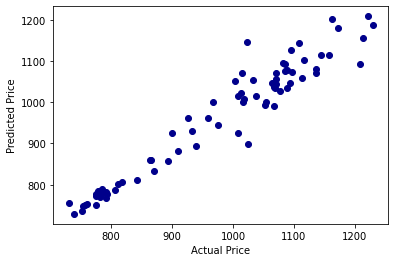

    The accuracy of the model is: 101.53
    Mean Absolute Error (MAE): 28.73
    Mean Squared Error (MSE) : 1555.44
    Root Mean Squared Error (RMSE): 39.44
*** Symbol: AAPL

    The r-squared score of the model 0.97 on 76 values.


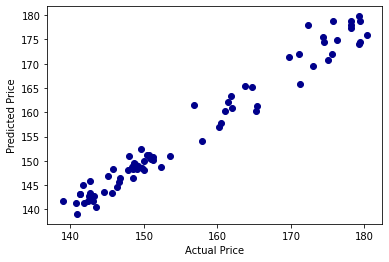

    The accuracy of the model is: 100.29
    Mean Absolute Error (MAE): 1.80
    Mean Squared Error (MSE) : 5.58
    Root Mean Squared Error (RMSE): 2.36
*** Symbol: MSFT

    The r-squared score of the model 0.94 on 76 values.


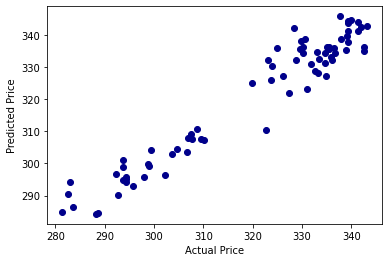

    The accuracy of the model is: 99.73
    Mean Absolute Error (MAE): 3.68
    Mean Squared Error (MSE) : 23.62
    Root Mean Squared Error (RMSE): 4.86
All get_stock_histories tests passed. Good. Notice we do not predict Volume as we have found no correlation to the model. Also ignore the warning on r-squred scores, we know that less than two test samples does not give an actual meaningful value. This is just for test purposes of our code.


,Symbol,Date,Open,High,Low,Close,Adj Close,Volume,Adj Close Next Day
0,TSLA,2022-01-01,1074.010521,1078.974105,1047.322726,1056.780029,1045.571852,NaN,1040.757492
1,TSLA,2022-01-02,1069.869078,1078.221107,1045.172821,1045.571852,1040.757492,NaN,1034.660804
2,TSLA,2022-01-03,1072.918514,1070.778063,1035.871667,1040.757492,1034.660804,NaN,1029.241970
3,TSLA,2022-01-04,1063.003720,1072.566451,1038.571088,1034.660804,1029.241970,NaN,1025.176137
4,TSLA,2022-01-05,1070.295409,1060.895227,1024.810702,1029.241970,1025.176137,NaN,1019.533835
...,...,...,...,...,...,...,...,...,...
70,MSFT,2022-01-21,345.519069,325.907220,324.201989,317.617635,323.029021,NaN,326.995358
71,MSFT,2022-01-22,327.211672,334.878417,333.702555,323.361432,326.995358,NaN,339.859836
72,MSFT,2022-01-23,339.553371,326.031703,323.776888,327.530069,339.859836,NaN,348.074679
73,MSFT,2022-01-24,317.579759,341.132136,339.269997,339.747063,348.074679,NaN,365.680389


In [251]:
def are_valid_symbols(symbols):
    '''
    INPUT:
    symbols - (array) List of stock tickers to evaluate if it is a valid list and all symbols
                    have an entry in the prediction model hash
    
    OUTPUT:
    error_msg - Optional error message when applicable, the reason why the given symbols list is not valid
    bool_ret - if False the given list is not valid
    
    Description:
    This validates the given list of symbols to make sure it is a valid list of symbols and each
    symbol has a corresponding entry in the model_hash dictionary 
    '''
    # First make sure we have a valid ticker list
    if (not symbols or len(symbols) == 0):
        return "Error: invalid or empty list of symbols passed.", False
    # Next make sure we have a trained model for the given tickers
    for symbol in symbols:
        if not symbol in model_hash.keys():
            return "Error: no trained model for symbol '{}'.".format(symbol), False
        
    return "", True

def evaluate_models(symbols, cv = None):
    '''
    INPUT:
    symbols - (array) List of stock tickers to evaluate prediction models for
    cv - Optional condition
    
    OUTPUT:
    error_msg - Optional error message when applicable, the reason why the given symbols list is not valid
    bool_ret - if False the given list is not valid
    
    Description:
    This iterates the given symbols and outputs the model evaluate_model function output
    '''
    means, mins, maxs = list(),list(),list()
    # Validate the symbols given
    error_msg, bool_ret = are_valid_symbols(symbols)
    if (not bool_ret):
        return error_msg, bool_ret, means, mins, maxs
    # Finally use the models to return the output of the evaluate_model function
    # record mean and min/max of each set of results if cv conditional value is *not* None
    for symbol in symbols:
        print("*** Symbol: {}\n".format(symbol))
        tm = model_hash[symbol]
        if cv is not None:
            k_mean, k_min, k_max = tm.evaluate_modelcv(cv)
            means.append(k_mean)
            mins.append(k_mean - k_min)
            maxs.append(k_max - k_mean)
        else:
            tm.evaluate_model()
    return "", True, means, mins, maxs
    
def get_stock_predictions(from_date, to_date, symbols, max_days_to_predict = 100):
    '''
    INPUT:
    from_date - (date) The starting date range to get data for 
    to_date - (date) The ending date range to get data for 
    symbols - (array) List of stock tickers to get stock prediction data for
    max_days_to_predict (int) - maximum number of days to predict into the future (sanity check)
    
    OUTPUT:
    error_msg - Optional error message when applicable, if empty the data frame is valid
    df_ret - Pandas data frame containing columns Symbol, Date, Open, High, Low, Close, Adj Close, and Adj Close Next Day
    
    Description:
    This is the query interface function that accepts a list of dates and a list of ticker symbols, 
    and outputs the predicted stock prices for each of those stocks on the given dates. 
    Note that the query dates passed in must be after the training date range, and ticker symbols 
    must be a subset of the ones trained on.
    '''
    # Initialize the return data frame as empty
    df_ret = pd.DataFrame()
    # Validate the symbols given
    error_msg, bool_ret = are_valid_symbols(symbols)
    if (not bool_ret):
        return error_msg, df_ret
    # Finally use the models to predict for the given tickers in the date range
    for symbol in symbols:
        tm = model_hash[symbol]
        # call this to get valid date objects newFromDate, newToDate
        error_msg, bool_val, newFromDate, newToDate = is_valid_range(from_date, to_date, True)
        # make sure the given date range is after the training date range
        if (newFromDate <= tm.last_trained_date):##tm.to_date):
            return "Error: query dates passed in must be after the training date range from '{}' to '{}'.".format(tm.from_date, tm.last_trained_date), df_ret
        # if we have a limit of how many days into the future to predict make sure we do not exceed that limit
        delta = newToDate - newFromDate
        if (max_days_to_predict > 0 and delta.days > max_days_to_predict):
            return "Error: given date range from '{}' to '{}' exceeds maximum number of days to predict {} by {} day(s).".format(newFromDate, newToDate, max_days_to_predict, (delta.days - max_days_to_predict)), df_ret
        # iterate over our date range one day at a time
        delta = datetime.timedelta(days=1)
        # start with one day beyond our training data or our test data because we build
        # off the last trained data row N
        current_date = tm.last_trained_date + delta
        # Initiate data frame to the last element of the training data
        df_curr = tm.df[tm.df['Date'] > tm.last_trained_date].head(1)
        # Iterate one day past because that is how we can predict to day N, by going to day N+1
        while current_date <= (newToDate + delta):
            # Predict using the model
            df_next = tm.predict(current_date, df_curr)
            # First iteration we are getting a prediction on the last train/test data, so we are getting a better N-1
            if (current_date == (tm.last_trained_date + delta)):
                df_curr = df_next
            else:
                df_curr = df_curr.append(df_next)
            current_date += delta
        # Remove day N+1
        df_curr.drop(df_curr.tail(1).index,inplace=True)
        # Remove days prior to N in the case of where we are predicting beyond the end of our test data
        df_curr = df_curr[df_curr['Date'] >= newFromDate]
        # Append our current symbol results to the overall df_ret dataframe
        df_ret = df_ret.append(df_curr, ignore_index=True)
    
    return "", df_ret
    
error_msg, bool_ret = are_valid_symbols([])
assert not bool_ret and error_msg == "Error: invalid or empty list of symbols passed.", "Did not get expected error message, instead got: {}".format(error_msg)
error_msg, bool_ret = are_valid_symbols( ['TSLA', 'ZVZZT', 'YHOO'])
assert not bool_ret and error_msg == "Error: no trained model for symbol 'ZVZZT'.", "Did not get expected error message, instead got: {}".format(error_msg)
error_msg, bool_ret = are_valid_symbols( ['TSLA'])
assert bool_ret and error_msg == "", "Did not get expected error message, instead got: {}".format(error_msg)

error_msg, bool_ret, means, mins, maxs = evaluate_models([])
assert not bool_ret and error_msg == "Error: invalid or empty list of symbols passed.", "Did not get expected False or error message, instead got: {} and {}".format(bool_ret, error_msg)
error_msg, bool_ret, means, mins, maxs = evaluate_models( ['TSLA', 'ZVZZT', 'YHOO'])
assert not bool_ret and error_msg == "Error: no trained model for symbol 'ZVZZT'.", "Did not get expected False or error message, instead got: {} and {}".format(bool_ret, error_msg)

today = datetime.datetime.today()
error_msg, df_ret = get_stock_predictions('2021-01-01', '2021-12-31', [])
assert error_msg == "Error: invalid or empty list of symbols passed.", "Did not get expected error message, instead got: {}".format(error_msg)
error_msg, df_ret = get_stock_predictions('2021-01-01', '2021-12-31', ['TSLA', 'ZVZZT', 'YHOO'])
assert error_msg == "Error: no trained model for symbol 'ZVZZT'.", "Did not get expected error message, instead got: {}".format(error_msg)
error_msg, df_ret = get_stock_predictions('2020-11-01', '2020-12-01', ['TSLA'])
assert error_msg == "Error: query dates passed in must be after the training date range from '2021-01-01 00:00:00' to '2021-09-14 00:00:00'.", "Did not get expected error message, instead got: {}".format(error_msg)
error_msg, df_ret = get_stock_predictions('2022-11-01', '2023-11-01', ['TSLA'])
assert error_msg == "Error: given date range from '2022-11-01 00:00:00' to '2023-11-01 00:00:00' exceeds maximum number of days to predict 100 by 265 day(s).", "Did not get expected error message, instead got: {}".format(error_msg)
error_msg, df_ret = get_stock_predictions('2022-01-01', today, ['TSLA', 'AAPL', 'MSFT'])
assert len(error_msg) == 0, "Did not get expected empty error message, instead got: {}".format(error_msg)
error_msg, bool_ret, means, mins, maxs  = evaluate_models( ['TSLA', 'AAPL', 'MSFT'])
assert bool_ret and error_msg == "", "Did not get expected True or error message, instead got: {} and {}".format(bool_ret, error_msg)
print("All get_stock_histories tests passed. Good. Notice we do not predict Volume as we have found no correlation to the model. Also ignore the warning on r-squred scores, we know that less than two test samples does not give an actual meaningful value. This is just for test purposes of our code.")
df_ret

And one last test to cover the case when we want to predict starting beyond just the day after our training data ends. Notice we still predict the same values because we always start at the end of the training data.

In [252]:
error_msg, df_ret2 = get_stock_predictions('2022-01-05', '2022-01-08', ['TSLA', 'AAPL', 'MSFT'])
assert len(error_msg) == 0, "Did not get expected empty error message, instead got: {}".format(error_msg)
print("All get_stock_histories tests passed. Good. Now to see how well we are predicting in the next section.")
df_ret2

All get_stock_histories tests passed. Good. Now to see how well we are predicting in the next section.


,Symbol,Date,Open,High,Low,Close,Adj Close,Volume,Adj Close Next Day
0,TSLA,2022-01-05,1070.295409,1060.895227,1024.810702,1029.241970,1025.176137,NaN,1019.533835
1,TSLA,2022-01-06,1052.814364,1067.686091,1034.128505,1025.176137,1019.533835,NaN,1016.947547
2,TSLA,2022-01-07,1068.811937,1049.015553,1011.860642,1019.533835,1016.947547,NaN,1010.550098
3,TSLA,2022-01-08,1038.417941,1065.287409,1033.062692,1016.947547,1010.550098,NaN,1009.826748
4,AAPL,2022-01-05,178.236797,179.233495,172.081062,174.191073,172.296115,NaN,170.172950
5,AAPL,2022-01-06,177.269249,179.308958,171.594078,172.683983,170.172950,NaN,168.266083
6,AAPL,2022-01-07,177.907011,178.301497,169.023266,170.636675,168.266083,NaN,165.858876
7,AAPL,2022-01-08,176.468708,178.033322,168.626020,168.786331,165.858876,NaN,163.890082
8,MSFT,2022-01-05,336.937468,341.514065,338.363039,344.985512,348.253892,NaN,350.929048
9,MSFT,2022-01-06,335.586111,344.124019,340.882561,348.254399,350.929048,NaN,353.849767


### Test and Measure Performance
##### How Good Are These Future Tesla, Apple, and Microsoft Predicitions?
We ran the following code over a few days after we ran this initially model and saved our results in `data/future_prices.csv`

```
df_future = pd.DataFrame()
start_date = '2022-01-03'
today = datetime.datetime.today()
tomorrow = today + datetime.timedelta(days=1)

symbol = 'TSLA'
df_ret3 = yf.download(symbol, start_date, tomorrow)
df_ret3 = df_ret3.reset_index()
df_ret3.insert(0, 'Symbol', symbol)
df_ret3['Symbol'] = symbol
df_ret3["Close"].plot()

df_future = df_future.append(df_ret3)

symbol = 'AAPL'
df_ret3 = yf.download(symbol, start_date, tomorrow)
df_ret3 = df_ret3.reset_index()
df_ret3.insert(0, 'Symbol', symbol)
df_ret3['Symbol'] = symbol
df_ret3["Close"].plot()

df_future = df_future.append(df_ret3)

symbol = 'MSFT'
df_ret3 = yf.download(symbol, start_date, tomorrow)
df_ret3 = df_ret3.reset_index()
df_ret3.insert(0, 'Symbol', symbol)
df_ret3['Symbol'] = symbol
df_ret3["Close"].plot()

df_future = df_future.append(df_ret3)

df_future.to_csv("data/future_prices_2022.csv", index=False)
```
Now let's read in that file and compare to our predictions above.

In [253]:
df_future = pd.read_csv('data/future_prices_2022.csv')

# Make sure our 'Date' column is actually a Date value
df_future['Date'] = pd.to_datetime(df_future['Date'])
# Just the Date part
df_future['Date'] = df_future['Date'].dt.date

# Show df to get an idea of the data
df_future

,Symbol,Date,Open,High,Low,Close,Adj Close,Volume
0,TSLA,2022-01-03,1147.750000,1201.069946,1136.040039,1199.780029,1199.780029,34643800
1,TSLA,2022-01-04,1189.550049,1208.000000,1123.050049,1149.589966,1149.589966,33416100
2,TSLA,2022-01-05,1146.650024,1170.339966,1081.010010,1088.119995,1088.119995,26706600
3,TSLA,2022-01-06,1077.000000,1088.000000,1020.500000,1064.699951,1064.699951,30112200
4,TSLA,2022-01-07,1080.369995,1080.829956,1010.000000,1026.959961,1026.959961,27849515
5,AAPL,2022-01-03,177.830002,182.880005,177.710007,182.009995,182.009995,104487900
6,AAPL,2022-01-04,182.630005,182.940002,179.119995,179.699997,179.699997,99310400
7,AAPL,2022-01-05,179.610001,180.169998,174.639999,174.919998,174.919998,94537600
8,AAPL,2022-01-06,172.699997,175.300003,171.639999,172.000000,172.000000,96904000
9,AAPL,2022-01-07,172.889999,174.139999,171.029999,172.169998,172.169998,85116663


    The r-squared score of the model 0.95 on 5 values.


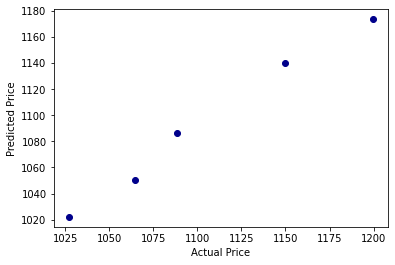

    The accuracy of the model is: 101.04
    Mean Absolute Error (MAE): 11.43
    Mean Squared Error (MSE) : 204.00
    Root Mean Squared Error (RMSE): 14.28
    The r-squared score of the model 0.99 on 5 values.


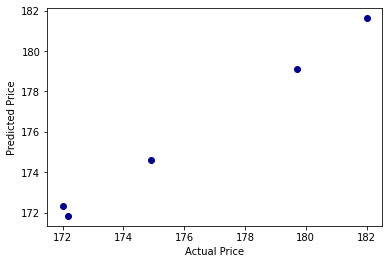

    The accuracy of the model is: 100.15
    Mean Absolute Error (MAE): 0.39
    Mean Squared Error (MSE) : 0.17
    Root Mean Squared Error (RMSE): 0.41
    The r-squared score of the model 0.88 on 5 values.


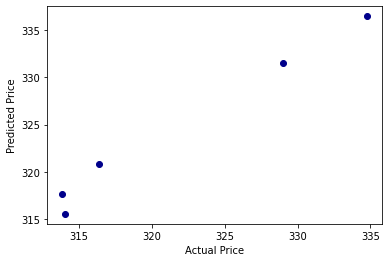

    The accuracy of the model is: 99.14
    Mean Absolute Error (MAE): 2.80
    Mean Squared Error (MSE) : 9.19
    Root Mean Squared Error (RMSE): 3.03


In [254]:
df_future_tesla = df_future[df_future['Symbol'] == 'TSLA']
df_future_apple = df_future[df_future['Symbol'] == 'AAPL']
df_future_msoft = df_future[df_future['Symbol'] == 'MSFT']

model_hash['TSLA'].evaluate_model(df_future_tesla[['Open', 'High', 'Low', 'Close', 'Adj Close']], df_future_tesla['Adj Close'])
model_hash['AAPL'].evaluate_model(df_future_apple[['Open', 'High', 'Low', 'Close', 'Adj Close']], df_future_apple['Adj Close'])
model_hash['MSFT'].evaluate_model(df_future_msoft[['Open', 'High', 'Low', 'Close', 'Adj Close']], df_future_msoft['Adj Close'])

Finally for our stock predictor, it is time to see how well we have actually done in predicting future adjusted closing prices for a larger data set: year 2021 last 2 months.

We will now implement a train-test cycle to measure the performance of the model. We will use it to test prediction accuracy for query dates at different intervals after the training end date, e.g. the day immediately after training end date, 7 days later, 14 days, 28 days, etc. So let us end the training data for about the last 60 days of the year and then test for November and December in increments.

In [255]:
# Clear the model hash
model_hash = {}

In [256]:
error_msg, bool_ret = get_stock_histories('2021-01-01', '2021-12-31', ['TSLA', 'AAPL', 'MSFT'], test_size = 60)
assert bool_ret and len(error_msg) == 0, "Did not get expected True and empty message, instead got: {} and {}".format(bool_ret, error_msg)
assert model_hash['TSLA'].last_trained_date.strftime('%Y-%m-%d') == '2021-10-06', "TSLA did not return expected last_trained_date, instead got: {}".format(model_hash['TSLA'].last_trained_date)
assert model_hash['AAPL'].last_trained_date.strftime('%Y-%m-%d') == '2021-10-06', "AAPL did not return expected last_trained_date, instead got: {}".format(model_hash['AAPL'].last_trained_date)
assert model_hash['MSFT'].last_trained_date.strftime('%Y-%m-%d') == '2021-10-06', "MSFT did not return expected last_trained_date, instead got: {}".format(model_hash['MSFT'].last_trained_date)
print("All get_stock_histories for the year completed with 60 remaining days set aside as test data. Good.")

All get_stock_histories for the year completed with 60 remaining days set aside as test data. Good.


*** Date: 2021-10-07
  Symbol   Adj Close  Adj Close Next Day
0   TSLA  793.609985          790.353529
1   AAPL  143.081177          143.325795
2   MSFT  294.311554          294.668155

*** Date: 2021-10-13
  Symbol   Adj Close  Adj Close Next Day
0   TSLA  811.080017          801.640161
1   AAPL  140.704651          141.233936
2   MSFT  295.768890          292.586617

*** Date: 2021-10-20
  Symbol   Adj Close  Adj Close Next Day
0   TSLA  865.799988          860.215411
1   AAPL  149.042480          148.431210
2   MSFT  306.848633          307.297397

*** Date: 2021-11-08
  Symbol    Adj Close  Adj Close Next Day
0   TSLA  1162.939941         1204.718648
1   AAPL   150.440002          150.913836
2   MSFT   336.374603          334.937285

*** Date: 2021-12-06
  Symbol    Adj Close  Adj Close Next Day
0   TSLA  1009.010010         1015.013536
1   AAPL   165.320007          161.153256
2   MSFT   326.190002          325.467436

*** Now evaluate for the entire test data or 2+ months
*** Sym

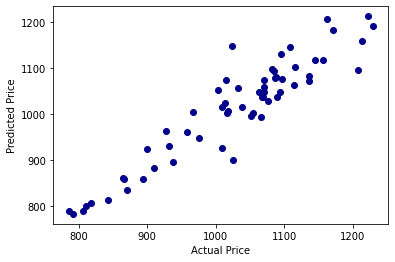

    The accuracy of the model is: 101.54
    Mean Absolute Error (MAE): 33.10
    Mean Squared Error (MSE) : 1875.77
    Root Mean Squared Error (RMSE): 43.31
*** Symbol: AAPL

    The r-squared score of the model 0.96 on 60 values.


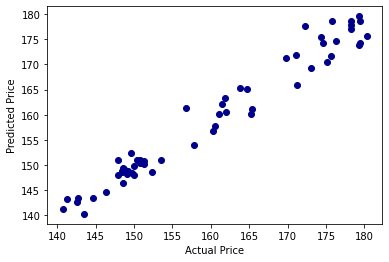

    The accuracy of the model is: 100.51
    Mean Absolute Error (MAE): 1.91
    Mean Squared Error (MSE) : 6.41
    Root Mean Squared Error (RMSE): 2.53
*** Symbol: MSFT

    The r-squared score of the model 0.88 on 60 values.


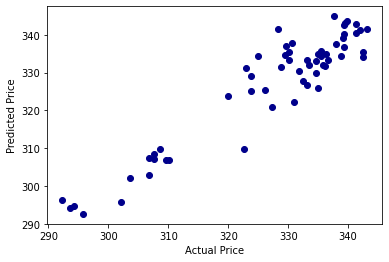

    The accuracy of the model is: 100.10
    Mean Absolute Error (MAE): 3.68
    Mean Squared Error (MSE) : 23.43
    Root Mean Squared Error (RMSE): 4.84


('', True, [], [], [])

In [257]:
# train-test cycle: the day immediately after training end date, and increments of 7 days, through the entire 2+ months...
symbols = ['TSLA', 'AAPL', 'MSFT']
for dt in ['2021-10-07', '2021-10-13', '2021-10-20', '2021-11-08', '2021-12-06']:
    error_msg, df_ret = get_stock_predictions(dt, dt, symbols)
    assert len(error_msg) == 0, "Did not get expected empty error message, instead got: {}".format(error_msg)
    print("*** Date: {}\n{}\n".format(dt, df_ret[['Symbol', 'Adj Close', 'Adj Close Next Day']]))
# And the entire test data or 2+ months
print("*** Now evaluate for the entire test data or 2+ months")
evaluate_models(symbols)

### Performance
So over a period of the last 60+ days of the year 2021, our linear model looks good for our 3 symbols, with an accuracy hovering around 100 and a scatter plot clustering relationship in a linear pattern.

Tesla seems to be very volatile as it has the highest MAE, MSE, and RMSE values of the 3 stocks, but Apple and Microsoft score much lower.

### Performance: k-Fold Cross-Validation
From ["A Gentle Introduction to k-fold Cross-Validation"](https://machinelearningmastery.com/k-fold-cross-validation/):
> Cross-validation is a statistical method used to estimate the skill of machine learning models.

And from ["How to Configure k-Fold Cross-Validation"](https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/): 
> The k-fold cross-validation procedure is a standard method for estimating the performance of a machine learning algorithm on a dataset.

I refactored the code for a k-Fold Cross Validation into the function `kfold_validation` so that we could run it for multiple names, starting with TSLA Tesla Motors.

*** Symbol: TSLA

cross_validate scores: {'fit_time': array([0.00498605, 0.01495814, 0.00498581, 0.01695347, 0.00598311,
       0.00698805, 0.00597835, 0.00299168, 0.00598478, 0.00598311,
       0.00498581, 0.00598478, 0.004987  , 0.00498748, 0.00398779,
       0.00498867, 0.00997162, 0.00498557, 0.004987  , 0.00398874,
       0.0079782 , 0.01595664, 0.00498509, 0.00997233, 0.00498652,
       0.00498605, 0.00498724, 0.00498486, 0.00797868, 0.00498843,
       0.0129652 , 0.00398874, 0.00499058, 0.00598407, 0.00499916,
       0.01595736, 0.00498652, 0.00498724, 0.00399017, 0.00498605,
       0.00500941, 0.004987  , 0.00498748, 0.00598264, 0.00598431,
       0.01296496, 0.00498652, 0.00498128, 0.00598454, 0.00598383,
       0.00598884, 0.00498724, 0.00498676, 0.00498009, 0.0069809 ,
       0.0079782 , 0.00897694, 0.00698972, 0.00598454, 0.00796866]), 'score_time': array([0.00398898, 0.00598574, 0.00498652, 0.00698113, 0.00299191,
       0.00498009, 0.00300336, 0.00299144, 0.00299191, 0.00

cross_validate scores: {'fit_time': array([0.00399137, 0.00299406, 0.00398993, 0.00398993, 0.00398803,
       0.00498509, 0.00398874, 0.00398779, 0.00498605, 0.00398898,
       0.00299144, 0.00399017, 0.00498581, 0.00299144]), 'score_time': array([0.00299168, 0.00299168, 0.00199437, 0.00199437, 0.00199461,
       0.00199461, 0.00299215, 0.0019958 , 0.00299215, 0.00299215,
       0.00299215, 0.00299144, 0.00199389, 0.00199461]), 'test_neg_mean_absolute_error': array([-45.2469112 , -25.46861705, -24.87996632, -30.20151902,
       -19.53091132, -15.52261527, -45.59034398, -43.24664305,
       -32.05817475, -27.79010278, -31.06574442, -44.88356055,
       -44.24200975, -38.04064028]), 'test_neg_root_mean_squared_error': array([-50.4208284 , -33.67233431, -28.6805848 , -36.90924706,
       -23.02902493, -20.95325432, -69.92358495, -48.2185237 ,
       -33.61488656, -34.90954575, -37.89408021, -56.23129833,
       -58.2838528 , -44.48992545]), 'test_r2': array([  0.66474642,   0.57405964,   

cross_validate scores: {'fit_time': array([0.00399208, 0.00299454, 0.00299454, 0.0039916 , 0.0039916 ,
       0.00398993, 0.00398993, 0.00498438, 0.00398612, 0.00398898,
       0.00399113, 0.00398993, 0.00398898, 0.00398898, 0.0039885 ,
       0.00398898, 0.00498629, 0.00498629, 0.00299215, 0.00398922]), 'score_time': array([0.00199437, 0.00299191, 0.00299191, 0.00199509, 0.00199509,
       0.00199246, 0.00199246, 0.00199485, 0.00199556, 0.00199556,
       0.00199342, 0.00199485, 0.00199485, 0.00299191, 0.0029912 ,
       0.0019958 , 0.00199413, 0.00199437, 0.00199437, 0.00199509]), 'test_neg_mean_absolute_error': array([-37.38856598, -40.96888262, -26.16140522, -31.44812407,
       -22.0624407 , -20.02763979, -35.75545051, -20.86238188,
       -17.6533988 , -12.15998413, -68.76979436, -43.51320139,
       -32.25939876, -32.192002  , -18.77642248, -30.39232268,
       -45.79515967, -24.96987796, -43.507532  , -44.87934042]), 'test_neg_root_mean_squared_error': array([-44.93415148, -47.

cross_validate scores: {'fit_time': array([0.00399041, 0.00399041, 0.00399137, 0.00399065, 0.00399065,
       0.00398898, 0.00399017, 0.00399041, 0.00398874, 0.00398946,
       0.00398803, 0.00398803, 0.0039897 , 0.0039897 , 0.00498676,
       0.00398755, 0.0039885 , 0.00398874, 0.00598645, 0.00698519,
       0.00797915, 0.00498343, 0.00498199, 0.00299263, 0.00398684,
       0.00199246]), 'score_time': array([0.00199533, 0.00299191, 0.00199294, 0.00199485, 0.00199485,
       0.00299311, 0.00199485, 0.00200438, 0.00199389, 0.00199509,
       0.00199461, 0.00299168, 0.00199342, 0.0029912 , 0.00199413,
       0.00199461, 0.00399184, 0.00399041, 0.00299287, 0.00298738,
       0.00199437, 0.00199461, 0.00199533, 0.0009973 , 0.00099897,
       0.00099897]), 'test_neg_mean_absolute_error': array([-37.38856598, -40.96888262, -26.16140522, -31.44812407,
       -22.0624407 , -20.02763979, -35.75545051, -20.86238188,
       -23.61651922,  -5.28325903, -17.51664216, -81.40479681,
       -38.880095

cross_validate scores: {'fit_time': array([0.00498867, 0.004987  , 0.00598407, 0.00598216, 0.00398731,
       0.00398922, 0.00299239, 0.00498652, 0.00299263, 0.00398993,
       0.00498891, 0.0039916 , 0.0039916 , 0.00498676, 0.00498819,
       0.00498676, 0.00498509, 0.00398755, 0.00498652, 0.00498867,
       0.004987  , 0.00498557, 0.00398898, 0.00598478, 0.00498772,
       0.00498772, 0.004987  , 0.0079782 , 0.00498486, 0.00498486]), 'score_time': array([0.00298953, 0.00199294, 0.00299025, 0.00199437, 0.0029912 ,
       0.0029912 , 0.00299072, 0.00099564, 0.00299096, 0.00299358,
       0.00199294, 0.0029912 , 0.0029912 , 0.00299311, 0.00299048,
       0.00299025, 0.00299382, 0.00299382, 0.00299239, 0.00299025,
       0.00698185, 0.00299311, 0.00299215, 0.00398874, 0.00299239,
       0.00299168, 0.00298953, 0.00199413, 0.00199413, 0.00199413]), 'test_neg_mean_absolute_error': array([-50.45762832, -40.27968327, -27.9008181 , -34.41168103,
       -22.40151713, -30.15146517, -20.18119679

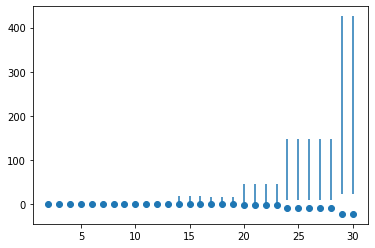

In [267]:
def kfold_validation(symbol: str):
    '''
    INPUT:
    from_date - (date) The starting date range to get data for 
    to_date - (date) The ending date range to get data for 
    symbols - (array) List of stock tickers to get stock prediction data for
    max_days_to_predict (int) - maximum number of days to predict into the future (sanity check)
    
    OUTPUT:
    error_msg - Optional error message when applicable, if empty the data frame is valid
    df_ret - Pandas data frame containing columns Symbol, Date, Open, High, Low, Close, Adj Close, and Adj Close Next Day
    
    Description:
    This is the query interface function that accepts a list of dates and a list of ticker symbols, 
    and outputs the predicted stock prices for each of those stocks on the given dates. 
    Note that the query dates passed in must be after the training date range, and ticker symbols 
    must be a subset of the ones trained on.
    '''
    symbols = [symbol]
    # calculate the ideal test condition
    error_msg, bool_ret, ideal, _, _ = evaluate_models(symbols, LeaveOneOut())
    ideal = ideal[0]
    print('Ideal: %.3f' % ideal)

    # define folds to test
    folds = range(2,31)

    # record mean and min/max of each set of results
    means, mins, maxs = list(),list(),list()
    # evaluate each k value
    for k in folds:
        # define the test condition
        cv = KFold(n_splits=k, shuffle=True, random_state=1)
        # evaluate k value
        error_msg, bool_ret, k_mean, k_min, k_max = evaluate_models(symbols, cv)
        # report performance
        print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean[0], k_min[0], k_max[0]))
        # store mean accuracy
        means.append(k_mean[0])
        # store min and max relative to the mean
        mins.append(k_mean[0] - k_min[0])
        maxs.append(k_max[0] - k_mean[0])

    # line plot of k mean values with min/max error bars
    plt.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
    # plot the ideal case in a separate color
    plt.plot(folds, [ideal for _ in range(len(folds))], color='r')
    # show the plot
    plt.show()

kfold_validation('TSLA')

The results suggest that for this model on this Tesla Motors (TLSA) stock, most k values underestimate the performance of the model compared to the ideal case. The results suggest that perhaps k=24 alone is slightly optimistic and perhaps k=29 might be a more accurate estimate. Let's try again for MSFT Microsoft.

*** Symbol: MSFT

cross_validate scores: {'fit_time': array([0.00399089, 0.00498772, 0.00498605, 0.00398874, 0.00399065,
       0.00399041, 0.01196718, 0.00797701, 0.01396632, 0.01196814,
       0.00797796, 0.00797963, 0.00598454, 0.00598526, 0.00598431,
       0.00498629, 0.00598216, 0.00498652, 0.00698066, 0.00598431,
       0.00498557, 0.00498843, 0.02194118, 0.00897574, 0.00797749,
       0.00498652, 0.00598431, 0.00398755, 0.00498581, 0.00398922,
       0.004987  , 0.004987  , 0.00398922, 0.00498724, 0.00498676,
       0.00598454, 0.00498652, 0.00997519, 0.01196814, 0.00498605,
       0.004987  , 0.00399017, 0.00498724, 0.00598717, 0.00697041,
       0.0049994 , 0.00498557, 0.00398946, 0.00498819, 0.00498605,
       0.00398731, 0.00498939, 0.00399208, 0.00598383, 0.00598335,
       0.00498366, 0.00498533, 0.00498676, 0.00398803, 0.00398946]), 'score_time': array([0.00299215, 0.00199533, 0.00199676, 0.00299215, 0.00299358,
       0.00299168, 0.00299239, 0.00398946, 0.00498629, 0.00

cross_validate scores: {'fit_time': array([0.00299335, 0.00399184, 0.00399113, 0.00399041, 0.00398922,
       0.00399065, 0.00399017, 0.00498509, 0.004987  , 0.00498843,
       0.00398993, 0.00498629, 0.00398755, 0.00398922]), 'score_time': array([0.00299239, 0.00299072, 0.00199389, 0.00199676, 0.00199604,
       0.00199175, 0.00299287, 0.00199509, 0.00199485, 0.00199318,
       0.00398755, 0.00199318, 0.00299239, 0.00299072]), 'test_neg_mean_absolute_error': array([-6.80844168, -4.1832097 , -3.02699065, -3.20039256, -1.24987678,
       -3.19106385, -5.45970232, -5.48991778, -4.97775847, -1.20003742,
       -1.49969239, -3.06006272, -2.5378098 , -2.66535124]), 'test_neg_root_mean_squared_error': array([-7.20577674, -5.78194366, -5.10193652, -3.84715254, -1.56938287,
       -3.45922992, -6.79790729, -6.02546013, -5.67943875, -1.56326123,
       -2.19300995, -3.52856176, -3.30143593, -2.90993798]), 'test_r2': array([ 0.74438289, -0.11086822,  0.88329173,  0.86230834,  0.82496029,
       

cross_validate scores: {'fit_time': array([0.00299311, 0.00498748, 0.00299501, 0.00498772, 0.00498796,
       0.00498796, 0.004987  , 0.0049839 , 0.0039885 , 0.00399041,
       0.00399613, 0.00299978, 0.00497937, 0.00398755, 0.00398827,
       0.00399041, 0.00498772, 0.00498605, 0.00498748, 0.00498748,
       0.00498509, 0.00299215, 0.00399065, 0.00299311, 0.00398779]), 'score_time': array([0.00299239, 0.00199628, 0.00299096, 0.00199461, 0.00199294,
       0.00199294, 0.00199461, 0.00199556, 0.00299978, 0.00100327,
       0.0019877 , 0.00298405, 0.00299239, 0.00199509, 0.00598598,
       0.00199461, 0.00299168, 0.00199437, 0.00299215, 0.00199366,
       0.00199652, 0.0009985 , 0.0019927 , 0.00299001, 0.0009973 ]), 'test_neg_mean_absolute_error': array([-6.55619115, -9.60539348, -2.71130548, -1.42793401, -4.13596921,
       -3.02435211, -2.693506  , -1.53446959, -3.45837941, -4.09194709,
       -4.85696361, -5.86507124, -5.19765008, -3.65171886, -5.34527663,
       -0.49012396, -1.98747

cross_validate scores: {'fit_time': array([0.00498772, 0.00498605, 0.004987  , 0.00399137, 0.00399303,
       0.00399041, 0.00398874, 0.00398469, 0.00498843, 0.00498605,
       0.00498581, 0.00598383, 0.00498986, 0.00797868, 0.00797677,
       0.01495886, 0.00598216, 0.00598407, 0.0119679 , 0.01096988,
       0.01097035, 0.00797725, 0.00697994, 0.01096916, 0.00698185,
       0.00797844, 0.00697994, 0.00698209, 0.00698113]), 'score_time': array([0.00199413, 0.00199628, 0.0019989 , 0.00199413, 0.00398469,
       0.00199318, 0.00299239, 0.00299215, 0.00299168, 0.00299382,
       0.00199461, 0.00299072, 0.00299025, 0.00398803, 0.00299239,
       0.00299215, 0.00299096, 0.00398922, 0.00398922, 0.00399089,
       0.00897741, 0.0039885 , 0.00498652, 0.00398922, 0.00398922,
       0.0039897 , 0.00398874, 0.00343132, 0.00398898]), 'test_neg_mean_absolute_error': array([-6.55619115, -9.60539348, -3.70874135, -1.29962988, -1.15026215,
       -5.86283639, -2.94195381, -1.89146028, -3.57905483, -0.

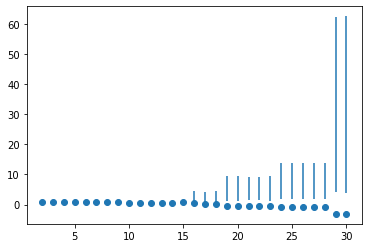

In [268]:
kfold_validation('MSFT')

The results again suggest similar model results for MSFT Microsoft stock, most k values underestimate the performance of the model compared to the ideal case. Although in this case we are closer to perhaps k=29 or k=30 a more accurate estimate. So as long we have 30 data points to train we have reasonable price predictions.

### Improvement
One of the improvements we could have made on our final Machine Learning model, we actually accomodated for in our final code. Rather than only assuming one type of model, Linear Regression notice our code relies on a base class `TrainedModel` so we could more easily swap out our `TrainedModelLinear` with say `TrainedModelLSTM` deep learning. From [Wikipedia: Long short-term memory](https://en.wikipedia.org/wiki/Long_short-term_memory):

> Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can process not only single data points (such as images), but also entire sequences of data (such as speech or video). For example, LSTM is applicable to tasks such as unsegmented, connected handwriting recognition, speech recognition and anomaly detection in network traffic or IDSs (intrusion detection systems).

Many of the existing Stock Predictor models I found online employ LSTM because of the sequential nature of the historical data.

Sidebar: There were headlines around Sentiment Analysis where bots picked up news of a fictional character dying on a Peloton bike. This prompted a sell off of the company stock prompting analysts to ask where the trading bots and algorithms fooled into confusing news of a fictional character's death as real news or where they actually smarter than that and knew it was a fictional character but anticipated how this would affect the actual company's image: [Peloton stock slumps after morbid product placement in "Sex and the City"](https://www.cbsnews.com/news/peloton-stock-death-by-peloton-just-like-that-mr-big)

> Shares of Peloton, the fitness equipment company, fell 11.3% Thursday — tumbling to a 19-month low — after a key character in HBO Max’s “Sex and the City” revival, “And Just Like That,” was shown dying of a heart attack after a 45-minute workout on one of the company’s exercise bikes.

### Refinement and Potential Improvements
Although all 3 have a decent linear fit r-square scores relatively close to 1 and overall accuracy within 100. Definite room for improvement here, perhaps analysis of additional indicators that are specific to the stock in question to analyze the health of the underlying company ("P/E ratio or price-to-earnings ratio, P/B ratio or price-to-book ratio, liquidity ratios, debt ratios, Return ratios, Margins, etc.") or even additional models beyond a linear fit or the basic technical analysis being done here. There are other forms of analysis that include NLP or Natural Language Processing where I can evaluate news, tweets, and social media posts associated to the company, otherwise known as Sentiment Analysis.

One other update we made was to introduce the shuffle=False parameters to all of our calls to `train_test_split`. Initially we commented out this call because we realized that splitting out test randomly (default behavior) did not make sense for sequentially timed data. However, with this parameter set to False, we can go back to using this function and save ourselves some lines of code. Thanks to the Udacity review feedback on this.

### <a class="anchor" id="Content-Based-Recommendations">Part V: Content Based Recommendations</a>

We also want to make some stock recommendations based on content. For example, you like Bitcon, perhaps you might like these other Crypto currency names that trade in the same price range, or perhaps you are interested in other tech sector names? So we got data from [SwingTradeBot.com](https://swingtradebot.com/equities?min_vol=1000&min_price=10.0&max_price=999999.0&adx_trend=&grade=&include_etfs=2&html_button=as_html) that gives us some charateristics across our stocks so that we may build a recommendation engine across factors.

`1.` Let us begin by reading in the SwingTradeBot.com data:

In [1014]:
df = pd.read_csv('data/all_stocks_swingtradebot_dot_com.csv')

# Show df to get an idea of the data
df.head()

,symbol,name,close_price,volume,vol_vs_avg,change_in_percent,days_old,adx,plus_di,minus_di,...,fifty_two_week_high,peg,eps,div_yield,atr,chandelier_exit_long,chandelier_exit_short,tradingview_symbol,sector,industry
0,A,"Agilent Technologies, Inc.",159.18,647168,0.44,0.28,602,13.90,24.8881,17.0034,...,179.5700,2.97,2.3000,0.490011,3.7089,148.7133,158.8467,NYSE:A,Healthcare,Diagnostics & Research
1,AA,Alcoa Inc.,59.19,3630151,0.43,-1.07,602,23.26,32.9055,14.3460,...,60.5900,-0.29,-3.1210,NaN,2.7161,52.4417,51.4170,NYSE:AA,Basic Materials,Aluminum
2,AAC,Ares Acquisition Corporation,9.74,8293,0.03,0.00,193,24.37,7.9866,14.7406,...,10.0000,NaN,NaN,NaN,0.0279,9.7364,9.8237,NYSE:AAC,Other,Other
3,AAC.U,"Ares Acquisition Corporation Units, each consi...",9.92,54232,1.52,-0.10,224,39.45,8.7218,39.1879,...,10.8032,NaN,NaN,NaN,0.0298,9.9506,9.9294,NYSE:AAC.U,NaN,NaN
4,AACG,ATA Creativity Global,1.17,26754,0.65,-0.85,602,39.83,10.8880,30.9675,...,19.7500,NaN,-0.6365,NaN,0.1332,1.3666,1.5196,NASDAQ:AACG,Consumer Defensive,Education & Training Services


In [1015]:
print("{} unique sectors, {} unique industries".format(len(df.sector.unique()), len(df.industry.unique())))
df.describe()

13 unique sectors, 177 unique industries


,close_price,volume,vol_vs_avg,change_in_percent,days_old,adx,plus_di,minus_di,fifty_two_week_low,fifty_two_week_high,peg,eps,div_yield,atr,chandelier_exit_long,chandelier_exit_short
count,1587.000000,1.587000e+03,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1119.000000,1298.000000,718.000000,1587.000000,1569.000000,1569.000000
mean,410.370544,9.942480e+05,0.750252,-0.670277,523.154379,22.665331,23.952564,21.218043,303.241363,477.964386,2.991421,-1383.509200,2.244671,8.178119,400.336733,405.428767
std,11285.212849,3.763756e+06,1.340902,2.445006,167.617214,9.807783,7.738745,6.789515,8555.022533,11521.230232,53.766795,11698.990458,2.828339,171.104149,10959.336047,10994.364998
min,1.030000,1.000000e+00,0.000000,-29.500000,2.000000,0.000000,0.000000,0.000000,0.185000,2.780000,-1057.290000,-99999.990000,0.000000,0.000000,1.189000,1.301100
25%,15.715000,6.236750e+04,0.430000,-1.150000,602.000000,15.805000,19.031100,16.948950,11.180000,25.484500,0.010000,0.124250,0.726361,0.518400,16.731300,17.822900
50%,58.320000,2.271610e+05,0.570000,-0.120000,602.000000,20.600000,23.915100,21.112200,39.161400,74.770000,1.710000,1.862000,1.513794,1.894100,56.813600,57.998600
75%,152.895000,6.715730e+05,0.780000,0.415000,602.000000,27.540000,28.574200,25.014350,109.005000,180.010000,3.050000,4.549250,2.724979,4.493100,147.110700,154.653300
max,449570.000000,7.642173e+07,42.020000,18.010000,606.000000,88.130000,59.631000,61.483300,340816.100000,454550.000000,844.200000,217.751000,45.328032,6813.997900,434108.006300,435494.493700


So where financial data is great for data science is that a lot of it is already numerical, great for modeling out of the gate. However, that is what makes it not as great for recommendations, like say movies or IBM articles. So for the numeric values, I will use the Pandas describe function to identify 25/50/75 percentiles to classify our numbers into binary columns, e.g. In25Pct_close_price, In50Pct_close_price, In75Pct_close_price, In100Pct_close_price, and we do this for volume, change in percent, days old, adx, ..., peg, eps, div_yield, and atr, etc. So based on the output above let's record the numbers we need to then categorize our data.

In [1016]:
df.describe()['close_price']['25%']

15.715

In [1017]:
# Capture the 25%, 50%, and 75% numbers for each of our columns we are interested in
columns = ["close_price","volume", "vol_vs_avg", "change_in_percent", "days_old", "adx", "plus_di", "minus_di"\
           , "fifty_two_week_low", "fifty_two_week_high", "peg", "eps", "div_yield", "atr", "chandelier_exit_long"\
           , "chandelier_exit_short"]
dictionary_of_dictionaries = {}
desc = df.describe()
for column in columns:
    new_dict = {}
    for num in ['25%', '50%', '75%']:
        new_dict[num] = desc[column][num]
    dictionary_of_dictionaries[column] = new_dict

def create_25_50_75_00_columns(dictionary_of_dictionaries=dictionary_of_dictionaries, df=df):
    '''
    INPUT:
    dictionary_of_dictionaries - dictionary containing for each numeric column to categorize, the number for the 
                                 first "25" 25% percentile, "50" 50% percentile, and "75" for 75% percentile
    df - pandas dataframe to add columns
    
    OUTPUT:
    Pandas dataframe containing the 4 new columns 
    
    Description:
    Return a Pandas data frame that has 4 new columns which categorize whether the given col_name column is in the 
    25th, 50th, 75th, or 100th percentile of values
    '''
    # Loop through dictionary_of_dictionaries keys
    for col_name in dictionary_of_dictionaries:
        dictionary = dictionary_of_dictionaries[col_name]
        new_col_name = 'Pct_' + col_name + '25'
        df_new = df
        dict25 = dictionary["25%"]
        dict50 = dictionary["50%"]
        dict75 = dictionary["75%"]
        df_new[new_col_name]= df_new[col_name].apply(lambda x: 1 if (x <= dict25) else 0)
        new_col_name = 'Pct_' + col_name + '50'
        df_new[new_col_name]= df_new[col_name].apply(lambda x: 1 if ((x > dict25) and (x <= dict50)) else 0)
        new_col_name = 'Pct_' + col_name + '75'
        df_new[new_col_name]= df_new[col_name].apply(lambda x: 1 if ((x > dict50) and (x <= dict75)) else 0)
        new_col_name = 'Pct_' + col_name + '00'
        df_new[new_col_name]= df_new[col_name].apply(lambda x: 1 if (x > dict75) else 0)
    
    return df_new

df_cat = create_25_50_75_00_columns(dictionary_of_dictionaries)
df_cat.head()

,symbol,name,close_price,volume,vol_vs_avg,change_in_percent,days_old,adx,plus_di,minus_di,...,Pct_atr75,Pct_atr00,Pct_chandelier_exit_long25,Pct_chandelier_exit_long50,Pct_chandelier_exit_long75,Pct_chandelier_exit_long00,Pct_chandelier_exit_short25,Pct_chandelier_exit_short50,Pct_chandelier_exit_short75,Pct_chandelier_exit_short00
0,A,"Agilent Technologies, Inc.",159.18,647168,0.44,0.28,602,13.90,24.8881,17.0034,...,1,0,0,0,0,1,0,0,0,1
1,AA,Alcoa Inc.,59.19,3630151,0.43,-1.07,602,23.26,32.9055,14.3460,...,1,0,0,1,0,0,0,1,0,0
2,AAC,Ares Acquisition Corporation,9.74,8293,0.03,0.00,193,24.37,7.9866,14.7406,...,0,0,1,0,0,0,1,0,0,0
3,AAC.U,"Ares Acquisition Corporation Units, each consi...",9.92,54232,1.52,-0.10,224,39.45,8.7218,39.1879,...,0,0,1,0,0,0,1,0,0,0
4,AACG,ATA Creativity Global,1.17,26754,0.65,-0.85,602,39.83,10.8880,30.9675,...,0,0,1,0,0,0,1,0,0,0


Let's now categorize the 13 unique sectors, 113 unique industries is probably too many for now. But maybe we can come back to that. Notice of the 13 there is one nan or NaN. We need to account for this perhaps as 'Unknown' sector. 

In [1018]:
df_cat['sector'] = df_cat['sector'].apply(lambda x: 'Unknown' if (pd.isnull(x)) else x)
for col_name in df.sector.unique():
    new_col_name = 'Sector_' + col_name
    df_cat[new_col_name]= df_cat['sector'].apply(lambda x: 1 if (x == col_name) else 0)
print (df_cat.sector.unique())
df_cat.head()

['Healthcare' 'Basic Materials' 'Other' 'Unknown' 'Consumer Defensive'
 'Financial Services' 'Industrials' 'Technology' 'Consumer Cyclical'
 'Real Estate' 'Communication Services' 'Energy' 'Utilities']


,symbol,name,close_price,volume,vol_vs_avg,change_in_percent,days_old,adx,plus_di,minus_di,...,Sector_Unknown,Sector_Consumer Defensive,Sector_Financial Services,Sector_Industrials,Sector_Technology,Sector_Consumer Cyclical,Sector_Real Estate,Sector_Communication Services,Sector_Energy,Sector_Utilities
0,A,"Agilent Technologies, Inc.",159.18,647168,0.44,0.28,602,13.90,24.8881,17.0034,...,0,0,0,0,0,0,0,0,0,0
1,AA,Alcoa Inc.,59.19,3630151,0.43,-1.07,602,23.26,32.9055,14.3460,...,0,0,0,0,0,0,0,0,0,0
2,AAC,Ares Acquisition Corporation,9.74,8293,0.03,0.00,193,24.37,7.9866,14.7406,...,0,0,0,0,0,0,0,0,0,0
3,AAC.U,"Ares Acquisition Corporation Units, each consi...",9.92,54232,1.52,-0.10,224,39.45,8.7218,39.1879,...,1,0,0,0,0,0,0,0,0,0
4,AACG,ATA Creativity Global,1.17,26754,0.65,-0.85,602,39.83,10.8880,30.9675,...,0,1,0,0,0,0,0,0,0,0


Let's limit df_cat to just the symbol/name/close_price/volume and the Sector_* and Pct_* columns for our dot product calculations.

In [1019]:
df_cat_new = df_cat.drop(['vol_vs_avg', 'change_in_percent', 'days_old', 'adx', 'plus_di', 'minus_di', 'fifty_two_week_low', 'fifty_two_week_high', 'peg', 'eps', 'div_yield', 'atr', 'chandelier_exit_long', 'chandelier_exit_short', 'tradingview_symbol'], axis = 1)
df_cat_new.head()

,symbol,name,close_price,volume,sector,industry,Pct_close_price25,Pct_close_price50,Pct_close_price75,Pct_close_price00,...,Sector_Unknown,Sector_Consumer Defensive,Sector_Financial Services,Sector_Industrials,Sector_Technology,Sector_Consumer Cyclical,Sector_Real Estate,Sector_Communication Services,Sector_Energy,Sector_Utilities
0,A,"Agilent Technologies, Inc.",159.18,647168,Healthcare,Diagnostics & Research,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,AA,Alcoa Inc.,59.19,3630151,Basic Materials,Aluminum,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,AAC,Ares Acquisition Corporation,9.74,8293,Other,Other,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AAC.U,"Ares Acquisition Corporation Units, each consi...",9.92,54232,Unknown,NaN,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,AACG,ATA Creativity Global,1.17,26754,Consumer Defensive,Education & Training Services,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


#### Our Stock Symbol Recommendation Given an Existing Symbol
Wall Street analysts typically look at stocks within the same sector or industry, but to give my recommendation engine some novelty and potential serendipity, I will build my recommendations to go across all sectors or industries and an option to only stick within similar sector/industry. That is the purpose of the sort_by_sector_industry boolean flag below.

In [1020]:
def make_content_recs(symbol, m=10, sort_by_sector_industry=False, df_cat_new=df_cat_new):
    '''
    INPUT:
    symbol - Input stock ticker to use as a basis for our recommendations
    m - (int) the number of recommendations you want back
    sort_by_sector_industry - (boolean) if true we sort by sector, industry as well otherwise we only sort by similarity
    df_cat_new - (matrix) the stock content matrix 
    
    OUTPUT:
    error_msg - optional, if there is an error in processing
    recs_symbol - list of top m symbol recommendations
    recs_name - list of top m name recommendations
    
    Description:
    Make stock symbol recommendations based on the give input symbol
    '''
    # First check the matrix contains the given symbol
    df_find = df_cat_new[df_cat_new['symbol'] == symbol]
    if (df_find.shape[0] == 0):
        return "*** Symbol '{}' does not exist".format(symbol), [], []
    
    # Drop the non-numeric columns
    df_numeric = df_cat_new.drop(df_cat_new.select_dtypes(['object']).columns, axis = 1)
    
    # compute similarity of each symbol to the provided symbol
    symbol_row = df_cat_new.loc[df_cat_new['symbol'] == symbol]
    symbol_row = df_numeric.iloc[symbol_row.index]
    predictions = df_numeric.dot(symbol_row.transpose())
    
    # to get similarity add up all the dot products per column and transpose, so you will have a list of 
    # articles not already in user_article_ids and we can sort by similarity score or sum of dot products
    predictions['similarity'] = predictions.sum(axis=1)
    # Get rid of the symbol we are matching against, we don't want that in the recommendations
    predictions = predictions.drop(symbol_row.index)
    # Get rid of NaNs
    predictions = predictions[predictions['similarity'].notna()]

    if sort_by_sector_industry:
        sector = df_find.iloc[0]['sector']
        df_cat_new2 = pd.concat([df_cat_new, predictions], axis = 1)
        recs = df_cat_new2[df_cat_new2['sector'] == sector]
        recs = recs.sort_values(axis = 0, by = 'similarity', ascending = False).head(m)
    else:
        predictions = predictions.sort_values(axis = 0, by = 'similarity', ascending = False)
        recs = df_cat_new.iloc[predictions.index.tolist()].head(m)

    # Return sorted matching names and symbols
    return "", recs['symbol'].tolist(), recs['name'].tolist() # return a list of the symobls in order from most to least similar

# test non-existent symbol
print('*** ERROR does not exist: ZZVZT', make_content_recs('ZZVZT'))
        
# test existing symbol
print('*** IBM:', make_content_recs('IBM'))
# both by any sector and by related sector to get different results
print('*** Apple any sector:', make_content_recs('AAPL'))
print('*** Apple SAME sector:', make_content_recs('AAPL', 10, True))


*** ERROR does not exist: ZZVZT ("*** Symbol 'ZZVZT' does not exist", [], [])
*** IBM: ('', ['AAPL', 'AMD', 'NVDA', 'BBIO', 'CCL', 'AMC', 'AVCT', 'BAC', 'AAL', 'BBD'], ['Apple Inc.', 'Advanced Micro Devices, Inc.', 'NVIDIA Corporation', 'BridgeBio Pharma, Inc.', 'Carnival Corporation', 'AMC Entertainment Holdings, Inc.', 'American Virtual Cloud Technologies, Inc.', 'Bank of America Corporation', 'American Airlines Group, Inc.', 'Banco Bradesco SA'])
*** Apple any sector: ('', ['AMD', 'NVDA', 'BBIO', 'CCL', 'AMC', 'AVCT', 'BAC', 'AAL', 'BBD', 'TSLA'], ['Advanced Micro Devices, Inc.', 'NVIDIA Corporation', 'BridgeBio Pharma, Inc.', 'Carnival Corporation', 'AMC Entertainment Holdings, Inc.', 'American Virtual Cloud Technologies, Inc.', 'Bank of America Corporation', 'American Airlines Group, Inc.', 'Banco Bradesco SA', 'Tesla Motors, Inc.'])
*** Apple SAME sector: ('', ['AMD', 'NVDA', 'FB', 'APPS', 'MSFT', 'ATVI', 'AEY', 'SQ', 'BB', 'AMAT'], ['Advanced Micro Devices, Inc.', 'NVIDIA Corpor

### Improvement: How I would improve the content based recommendation system? 
Notice that even though we were looking at two technology stocks: IBM and Apple, the recommendation engine actually gave us some symbols or names not in the technology sector: a pharma BridgeBio Pharma, Inc., a leisure and travel one Carnival Corporation, an entertainment one AMC, and even a bank Bank of America Corporation. But how to measure and improve our recommendations? We could compare against what other online recommendation engines make. Sites like [seekingaplha.com](https://seekingalpha.com) will provide stock recommendations by sector but that comes at a premium. In fact, we'll be hard pressed to find anything online that will give us these types of recommendations. At best, for a stock like Apple, we can find some online articles or sites (https://www.tipranks.com, https://finance.yahoo.com, or https://marketchameleon.com) that recommend similar symbols and we can see AMD, NVDA, TSLA, among others also appear in these type of recommendations. But this is just a small sample of data and not enough to tell us how precise our picks are. So this evaluation is left as a potential future exercise, at best.

`3.` For the classic "cold start" problem with our content-recommendation system we would probably fall back to top volume traded or sort by VWAP (Volume Weighted Average Price) to sort by best value.

In [1021]:
def get_top_stocks(m=10, sector='', df_cat_new=df_cat_new):
    '''
    INPUT:
    m - (int) the number of recommendations you want back
    sector - (str) for a given sector
    df_cat_new - (matrix) the stock content matrix 
    
    OUTPUT:
    error_msg - optional, if there is an error in processing
    recs_symbol - list of top m symbol recommendations
    recs_name - list of top m name recommendations
    
    Description:
    Make stock symbol recommendations for an optional sector or for all sectors
    '''
    # First check the matrix contains the given sector if given
    predictions = df_cat_new
    if (len(sector) > 0):
        df_find = df_cat_new[df_cat_new['sector'] == sector]
        if (df_find.shape[0] == 0):
            return "Sector '{}' does not exist, try one of {}".format(sector, df_cat_new.sector.unique()), [], []
        predictions = df_find
    
    predictions = predictions.sort_values(axis = 0, by = 'volume', ascending = False).head(m)
    # Return sorted matching names and symbols
    return "", predictions['symbol'].tolist(), predictions['name'].tolist() # return a list of the symobls in order from most to least similar

# make recommendations for a brand new user no stock picked yet...just return the top volume stocks
print ('Top 10:', get_top_stocks(10))

# Test a bad sector
print ('XYZ', get_top_stocks(10, 'XYZ'))

# Get top Healthcare stocks
print ('Healthcare', get_top_stocks(10, 'Healthcare'))

Top 10: ('', ['AAPL', 'AMD', 'NVDA', 'BBIO', 'CCL', 'AMC', 'AVCT', 'BAC', 'AAL', 'BBD'], ['Apple Inc.', 'Advanced Micro Devices, Inc.', 'NVIDIA Corporation', 'BridgeBio Pharma, Inc.', 'Carnival Corporation', 'AMC Entertainment Holdings, Inc.', 'American Virtual Cloud Technologies, Inc.', 'Bank of America Corporation', 'American Airlines Group, Inc.', 'Banco Bradesco SA'])
XYZ ("Sector 'XYZ' does not exist, try one of ['Healthcare' 'Basic Materials' 'Other' 'Unknown' 'Consumer Defensive'\n 'Financial Services' 'Industrials' 'Technology' 'Consumer Cyclical'\n 'Real Estate' 'Communication Services' 'Energy' 'Utilities']", [], [])
Healthcare ('', ['BBIO', 'BFRI', 'NVAX', 'MRNA', 'ALLK', 'ARDX', 'AKBA', 'MDT', 'BSX', 'BMY'], ['BridgeBio Pharma, Inc.', 'Biofrontera Inc.', 'Novavax, Inc.', 'Moderna, Inc.', 'Allakos Inc.', 'Ardelyx, Inc.', 'Akebia Therapeutics, Inc.', 'Medtronic Inc.', 'Boston Scientific Corporation', 'Bristol-Myers Squibb Company'])


### <a class="anchor" id="Summary-and-Conclusion">Part V: Summary and Conclusion</a>

### Summary

> Congratulations!  You have reached the end of the Investment and Trading Capstone project! 

We explored the Yahoo! Finance historical trading data including using the Yahoo! Finance API to get live historical data. We also loaded well known financial indicator data, did some analysis and clean up of this data, and showed there was not enough significant correlation to our pricing models to warrant their use. So although we disproved our initial assumption that this financial indicator would help us in predicting closing prices, this meant that our model was a little easier to implement. We then created a Stock Predictor to predict Adjusted Closing prices based on previous day's closing data, and finally created a Content-Based Recommendation Engine to suggest similar Stocks based on most similiar Stock attributes for a given Stock.

### Model Evaluation and Validation
We demonstrated different techniques to evaluate our model and validate our results. Both academic techniques were shown and explained like Root Mean Square Error and R-squared best fit scores, but also visual plots to show how actual and predicted prices aligned in a linear pattern. Finally, empirical techniques such as comparing our accuracy based on 2022 actual prices were also demonstrated. Had we bought one USD Bitcoin how would we have fared at the end of the day?

We also went a step further, after our initial Udacity review, and introduced a k-fold cross validation or sensitivy analysis across k.

### Justification
We have shown that although adding leading market indicators to our model made sense on the surface, that at the end there just was not enough correlation to our results to warrant or justify why we should add these additional inputs to our machine learning model. The numbers do not lie. In fact, given the amount of work done to massage the raw inputs for these indicators, it was a good thing that we did not need them in the end.

### Conclusion

#### Reflection
This was a very fun project for me. Being able to choose a subject matter that I both find interesting and familiar, yet looking at it with a Data Science lens, made this work fascinating to me. It was a great opportunity to apply everything I learned and showcase how it could be applied to a real world problem and one that is close to home. The hardest part was to stop adding extra work. I probably could have kept working on this, thinking of new ways to model and test this. By far the best project in the Udacity program.

We now have the code basis for deploying a web application that will both showcase our Stock Predictor for Adjusted Closing price and our Content-Based Recommendation Engine. This way I can reach a wider audience. The results of this Jupyter Notebook will be saved to an html file below:

In [269]:
from subprocess import call
call(['python', '-m', 'nbconvert', '--to', 'html', 'Investment_and_Trading_Capstone.ipynb'])

0